# Attempt classification on 5 different orgs as a pretraining task to 5G Copper prediction tasks

In [1]:
import torch
from torch import nn

import altair as alt
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

import time


import models as m
import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec
import viz as v

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## Load 5 organism data
Splits pre-generated in `extract_seqs_from_org_genbanks.ipynb`

In [3]:
model_res = {}
pred_dfs = {}

___Running CV0___


E:338 | train loss:0.124 | val loss: 0.463:   7%|▋         | 339/5000 [03:42<50:50,  1.53it/s]

EarlyStopping counter: 125 out of 500


E:463 | train loss:0.082 | val loss: 0.510:   9%|▉         | 464/5000 [05:04<49:36,  1.52it/s]

EarlyStopping counter: 250 out of 500


E:588 | train loss:0.058 | val loss: 0.564:  12%|█▏        | 589/5000 [06:26<48:12,  1.53it/s]

EarlyStopping counter: 375 out of 500


E:713 | train loss:0.045 | val loss: 0.587:  14%|█▍        | 713/5000 [07:47<46:53,  1.52it/s]

EarlyStopping counter: 500 out of 500
Early stopping


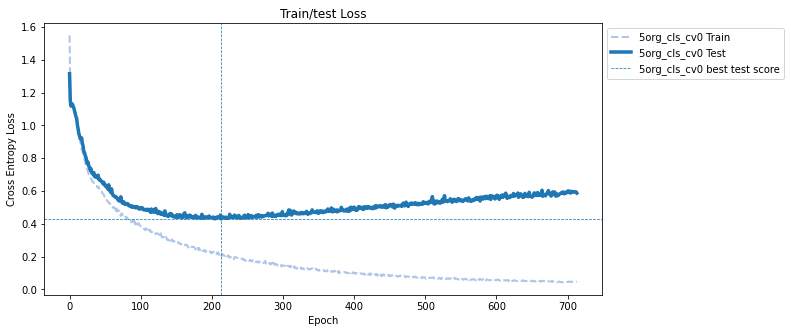

Running predictions for 5org_cls_cv0
___Running CV1___


E:304 | train loss:0.103 | val loss: 0.502:   6%|▌         | 305/5000 [03:18<50:57,  1.54it/s]

EarlyStopping counter: 125 out of 500


E:429 | train loss:0.058 | val loss: 0.570:   9%|▊         | 430/5000 [04:40<49:38,  1.53it/s]

EarlyStopping counter: 250 out of 500


E:554 | train loss:0.042 | val loss: 0.655:  11%|█         | 555/5000 [06:01<48:30,  1.53it/s]

EarlyStopping counter: 375 out of 500


E:679 | train loss:0.028 | val loss: 0.691:  14%|█▎        | 679/5000 [07:23<46:59,  1.53it/s]


EarlyStopping counter: 500 out of 500
Early stopping


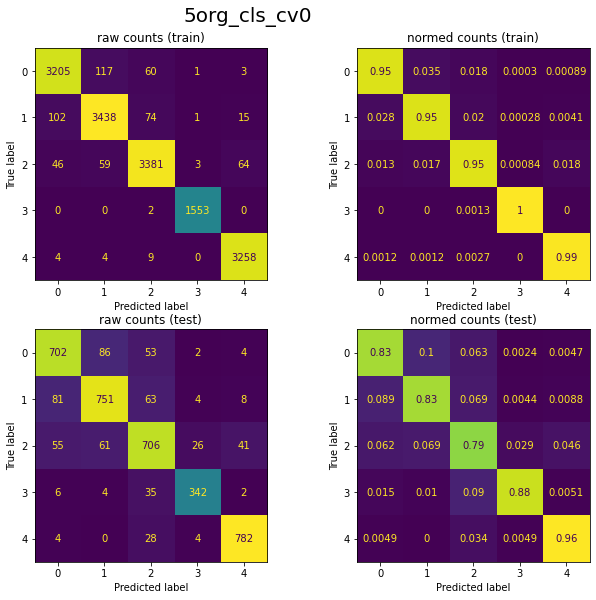

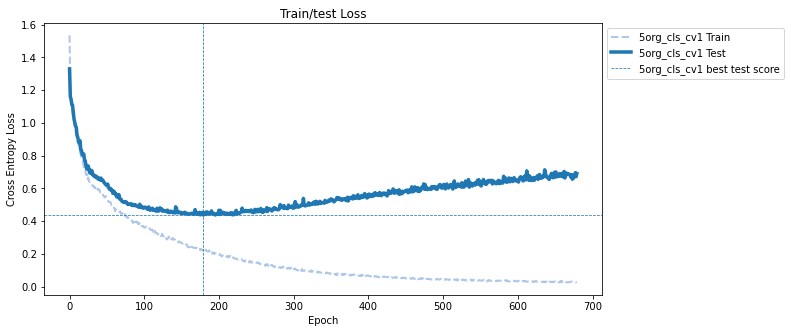

Running predictions for 5org_cls_cv1
___Running CV2___


E:311 | train loss:0.089 | val loss: 0.519:   6%|▌         | 312/5000 [03:25<51:34,  1.51it/s]

EarlyStopping counter: 125 out of 500


E:436 | train loss:0.048 | val loss: 0.634:   9%|▊         | 437/5000 [04:47<49:48,  1.53it/s]

EarlyStopping counter: 250 out of 500


E:561 | train loss:0.033 | val loss: 0.686:  11%|█         | 562/5000 [06:09<49:09,  1.50it/s]

EarlyStopping counter: 375 out of 500


E:686 | train loss:0.023 | val loss: 0.798:  14%|█▎        | 686/5000 [07:31<47:19,  1.52it/s]


EarlyStopping counter: 500 out of 500
Early stopping


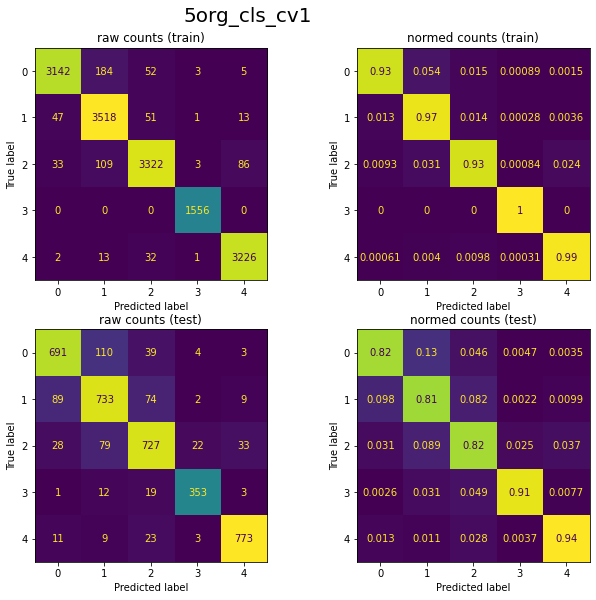

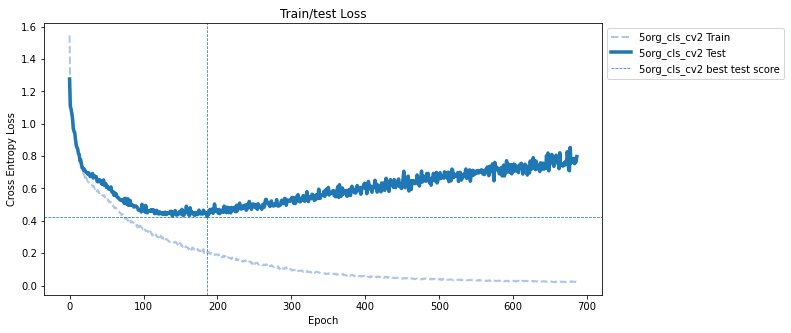

Running predictions for 5org_cls_cv2
___Running CV3___


E:321 | train loss:0.111 | val loss: 0.514:   6%|▋         | 322/5000 [03:30<50:48,  1.53it/s]

EarlyStopping counter: 125 out of 500


E:446 | train loss:0.069 | val loss: 0.538:   9%|▉         | 447/5000 [04:52<49:35,  1.53it/s]

EarlyStopping counter: 250 out of 500


E:571 | train loss:0.056 | val loss: 0.591:  11%|█▏        | 572/5000 [06:14<48:50,  1.51it/s]

EarlyStopping counter: 375 out of 500


E:696 | train loss:0.036 | val loss: 0.630:  14%|█▍        | 696/5000 [07:37<47:11,  1.52it/s]


EarlyStopping counter: 500 out of 500
Early stopping


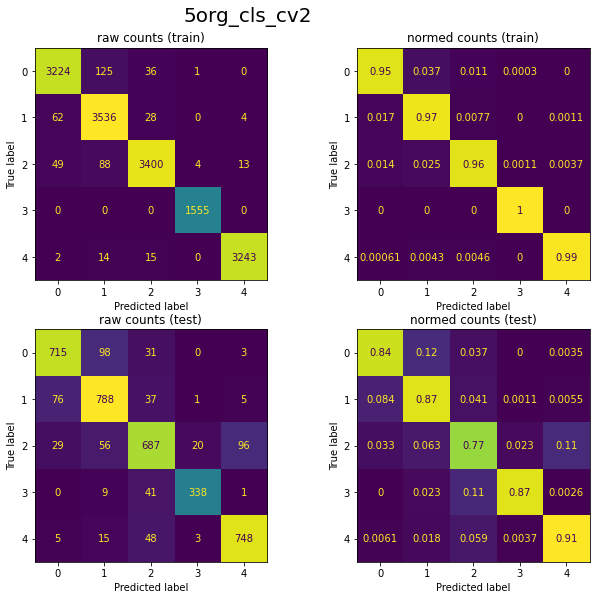

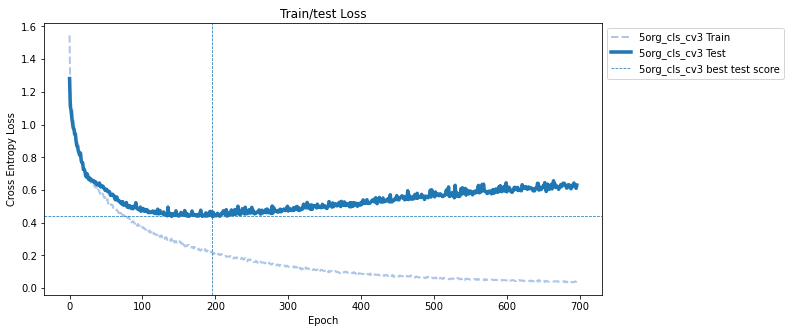

Running predictions for 5org_cls_cv3
___Running CV4___


E:314 | train loss:0.099 | val loss: 0.484:   6%|▋         | 315/5000 [03:27<51:18,  1.52it/s]

EarlyStopping counter: 125 out of 500


E:439 | train loss:0.055 | val loss: 0.542:   9%|▉         | 440/5000 [04:50<50:03,  1.52it/s]

EarlyStopping counter: 250 out of 500


E:564 | train loss:0.036 | val loss: 0.594:  11%|█▏        | 565/5000 [06:12<48:38,  1.52it/s]

EarlyStopping counter: 375 out of 500


E:689 | train loss:0.026 | val loss: 0.645:  14%|█▍        | 689/5000 [07:34<47:24,  1.52it/s]


EarlyStopping counter: 500 out of 500
Early stopping


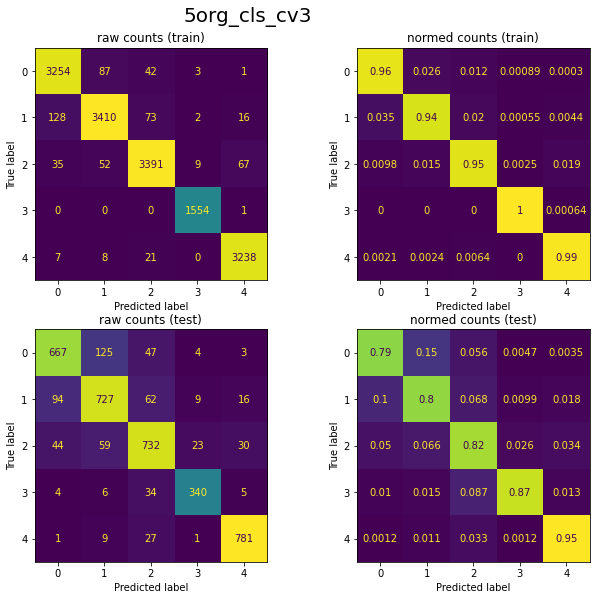

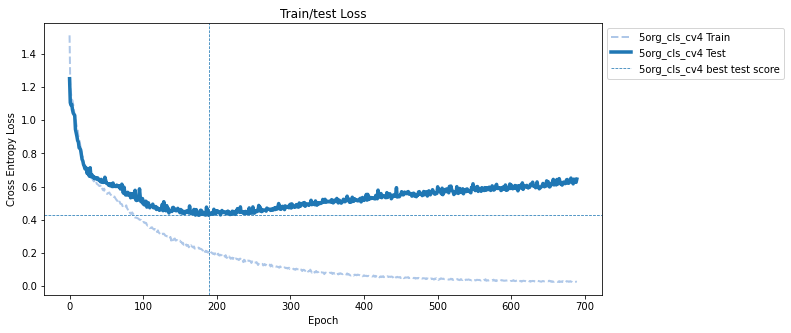

Running predictions for 5org_cls_cv4


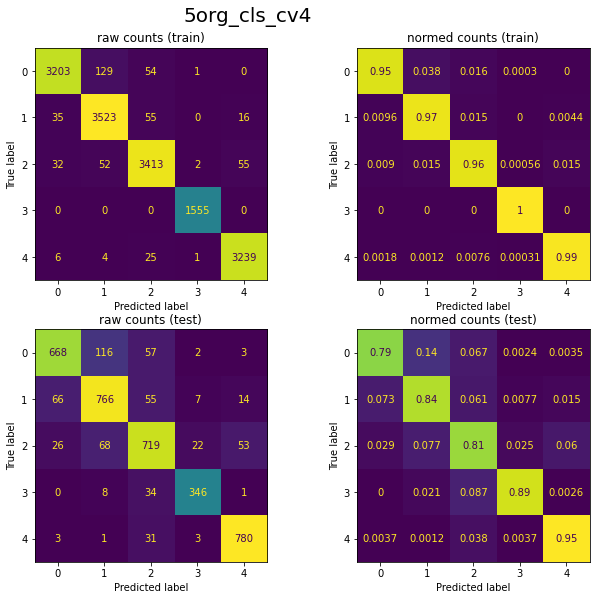

In [7]:
target_col = 'id'
seq_col = 'upstream_region'

# for each cv
for i in [0,1,2,3,4]:
    print(f"___Running CV{i}___")
    train_df = pd.read_csv(f'data/5org_ups_cls_splits/cv{i}_train.tsv',sep='\t')
    test_df = pd.read_csv(f'data/5org_ups_cls_splits/cv{i}_test.tsv',sep='\t')
    seq_len = len(train_df[seq_col].values[0])
    
    # sequences to predict on after training
    seq_list = [
        (train_df[seq_col].values,train_df[target_col],"train"),
        (test_df[seq_col].values,test_df[target_col],"test")
    ]

    # create data loaders
    sampler = tu.make_weighted_sampler(train_df,target_col)
    
    dataset_types = [
        DatasetSpec('ohe'),
    ]

    dls = tu.build_dataloaders(
                    train_df, 
                    test_df, 
                    dataset_types, # just OHE for now
                    seq_col=seq_col,
                    target_col=target_col,
                    sampler=sampler,
                    shuffle=False,
                )
    ohe_train_dl,ohe_val_dl = dls['ohe']
    
    m_args = (seq_len,5)
    m_kwargs = {
        "num_filters1":32,
        "num_filters2":32,
        "kernel_size1":10,
        "kernel_size2":6,
        "conv_pool_size1":2,
        "fc_node_num1":50,
        "fc_node_num2":50,
        "dropout1":0.25
    }
    
    model = m.DNA_2CNN_2FC(*m_args,**m_kwargs)
    model_name = f"5org_cls_cv{i}"

    # +-------------+
    # | TRAIN MODEL |
    # +-------------+
    t_res = tu.collect_model_stats(
        model_name,
        seq_len,
        ohe_train_dl,
        ohe_val_dl,
        DEVICE,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model,
        loss_type='classification'
    )

    model_res[model_name] = t_res
    
    # +------------+
    # | EVAL MODEL |
    # +------------+
    p_res_df = tu.get_confusion_stats(
        t_res['model'],
        t_res['model_name'],
        seq_list,
        DEVICE,
        title=f"{t_res['model_name']}",
    )
    
    p_res_df['model_type'] = "CNN"
    p_res_df['seq_mode'] = "regular"
    p_res_df['fold'] = i # which cv split
    p_res_df['task'] = '5org_cls'
    p_res_df['best_val_score'] = t_res['best_val_score']
    p_res_df['epoch_stop'] = t_res['epoch_stop']
    p_res_df['total_time'] = t_res['total_time']
    
    pred_dfs[model_name] = p_res_df
    
    
    
    

### Running 5 org classification for shuffled seqs

___Running CV0___


E:162 | train loss:0.626 | val loss: 1.316:   3%|▎         | 163/5000 [01:47<52:45,  1.53it/s]

EarlyStopping counter: 125 out of 500


E:287 | train loss:0.286 | val loss: 1.873:   6%|▌         | 288/5000 [03:09<51:45,  1.52it/s]

EarlyStopping counter: 250 out of 500


E:412 | train loss:0.147 | val loss: 2.373:   8%|▊         | 413/5000 [04:31<50:18,  1.52it/s]

EarlyStopping counter: 375 out of 500


E:537 | train loss:0.097 | val loss: 2.677:  11%|█         | 537/5000 [05:53<48:58,  1.52it/s]

EarlyStopping counter: 500 out of 500
Early stopping


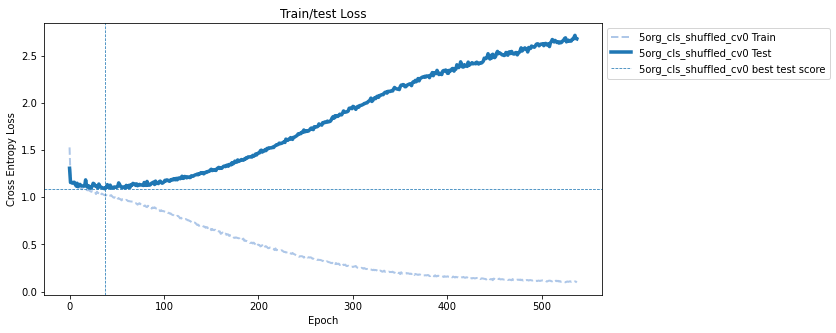

Running predictions for 5org_cls_shuffled_cv0
___Running CV1___


E:168 | train loss:0.628 | val loss: 1.348:   3%|▎         | 169/5000 [01:50<52:35,  1.53it/s]

EarlyStopping counter: 125 out of 500


E:293 | train loss:0.350 | val loss: 1.778:   6%|▌         | 294/5000 [03:12<51:40,  1.52it/s]

EarlyStopping counter: 250 out of 500


E:418 | train loss:0.209 | val loss: 2.236:   8%|▊         | 419/5000 [04:34<50:35,  1.51it/s]

EarlyStopping counter: 375 out of 500


E:543 | train loss:0.141 | val loss: 2.558:  11%|█         | 543/5000 [05:56<48:48,  1.52it/s]


EarlyStopping counter: 500 out of 500
Early stopping


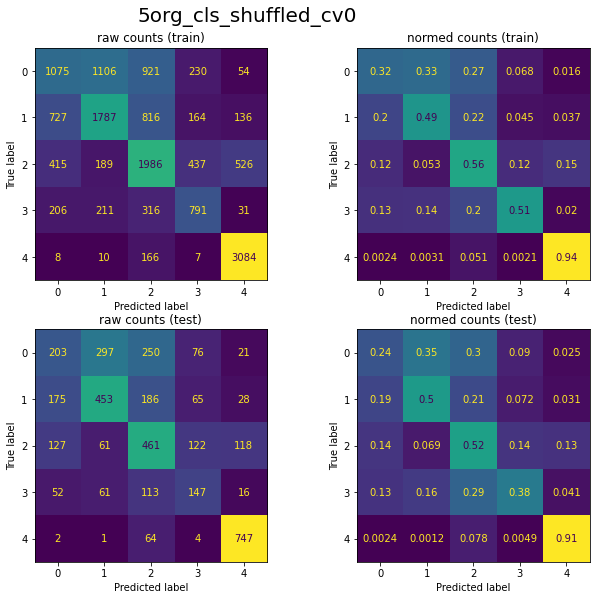

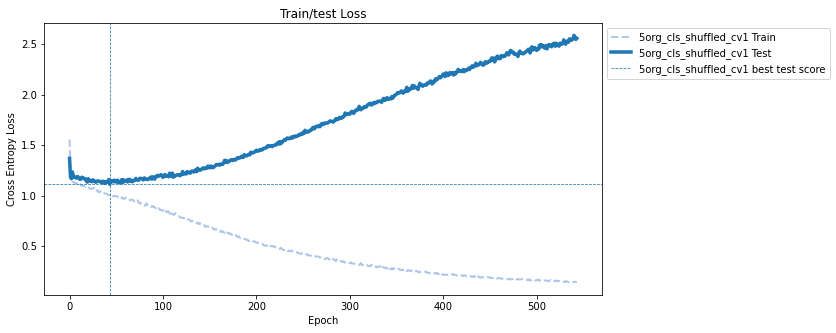

Running predictions for 5org_cls_shuffled_cv1
___Running CV2___


E:155 | train loss:0.716 | val loss: 1.237:   3%|▎         | 156/5000 [01:42<52:54,  1.53it/s]

EarlyStopping counter: 125 out of 500


E:280 | train loss:0.406 | val loss: 1.633:   6%|▌         | 281/5000 [03:04<51:38,  1.52it/s]

EarlyStopping counter: 250 out of 500


E:405 | train loss:0.246 | val loss: 2.066:   8%|▊         | 406/5000 [04:26<50:07,  1.53it/s]

EarlyStopping counter: 375 out of 500


E:530 | train loss:0.158 | val loss: 2.358:  11%|█         | 530/5000 [05:47<48:54,  1.52it/s]


EarlyStopping counter: 500 out of 500
Early stopping


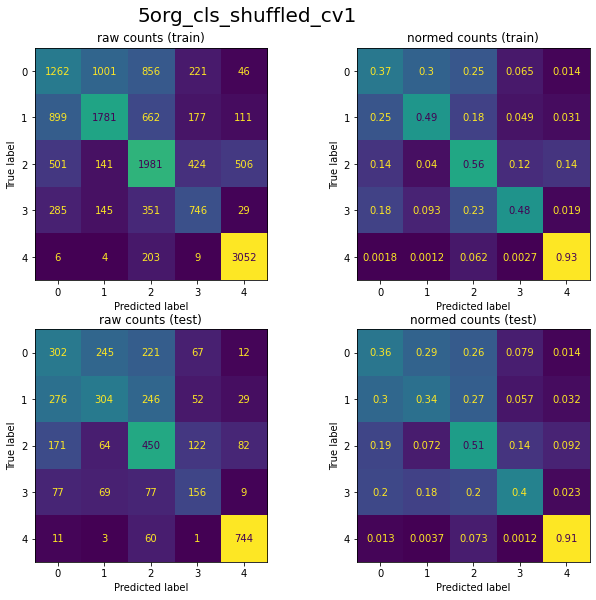

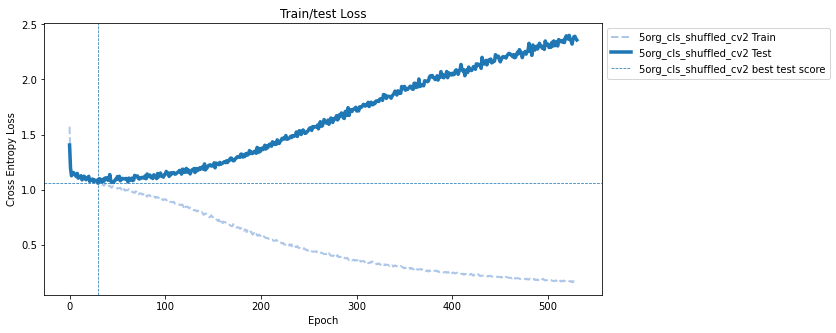

Running predictions for 5org_cls_shuffled_cv2
___Running CV3___


E:173 | train loss:0.654 | val loss: 1.268:   3%|▎         | 174/5000 [01:54<52:51,  1.52it/s]

EarlyStopping counter: 125 out of 500


E:298 | train loss:0.344 | val loss: 1.713:   6%|▌         | 299/5000 [03:16<51:23,  1.52it/s]

EarlyStopping counter: 250 out of 500


E:423 | train loss:0.183 | val loss: 2.178:   8%|▊         | 424/5000 [04:38<50:09,  1.52it/s]

EarlyStopping counter: 375 out of 500


E:548 | train loss:0.118 | val loss: 2.493:  11%|█         | 548/5000 [06:00<48:50,  1.52it/s]


EarlyStopping counter: 500 out of 500
Early stopping


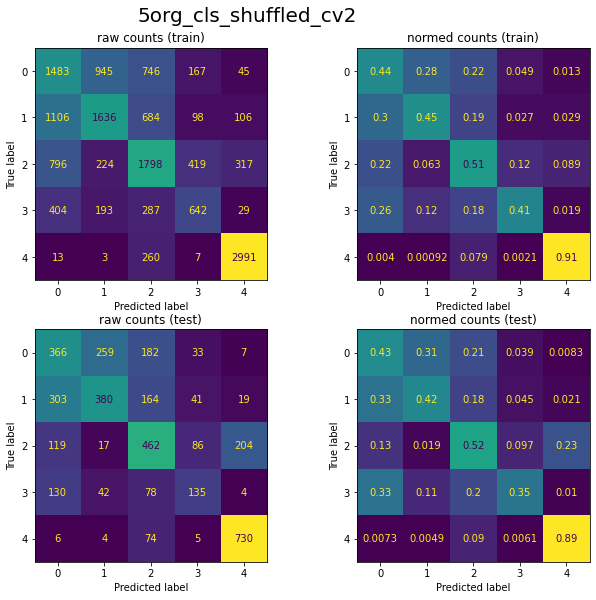

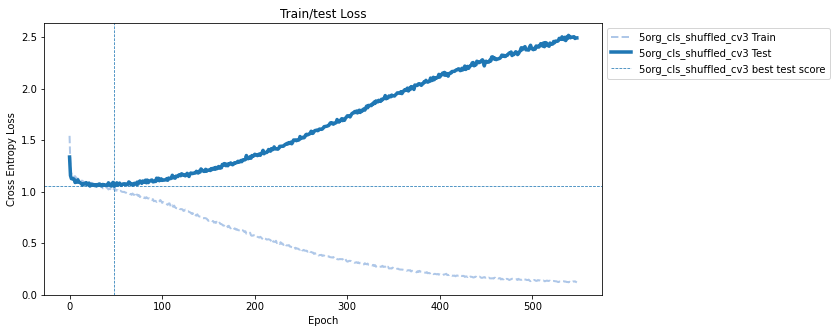

Running predictions for 5org_cls_shuffled_cv3
___Running CV4___


E:164 | train loss:0.695 | val loss: 1.206:   3%|▎         | 165/5000 [01:49<53:16,  1.51it/s]

EarlyStopping counter: 125 out of 500


E:289 | train loss:0.363 | val loss: 1.609:   6%|▌         | 290/5000 [03:11<52:01,  1.51it/s]

EarlyStopping counter: 250 out of 500


E:414 | train loss:0.211 | val loss: 2.018:   8%|▊         | 415/5000 [04:34<50:31,  1.51it/s]

EarlyStopping counter: 375 out of 500


E:539 | train loss:0.135 | val loss: 2.327:  11%|█         | 539/5000 [05:57<49:17,  1.51it/s]


EarlyStopping counter: 500 out of 500
Early stopping


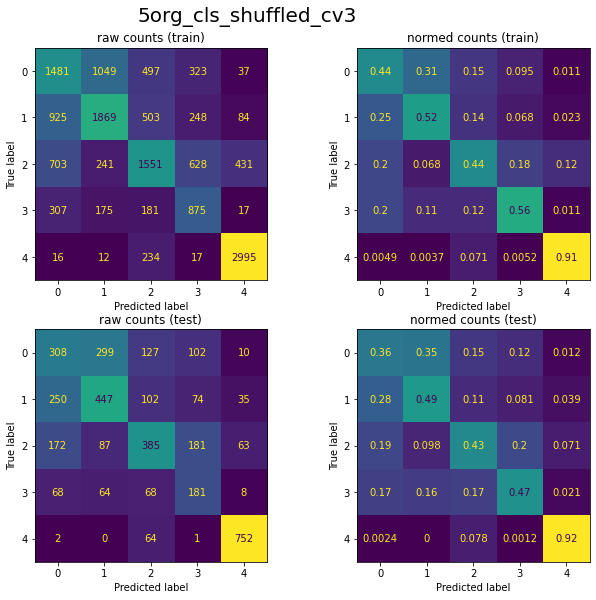

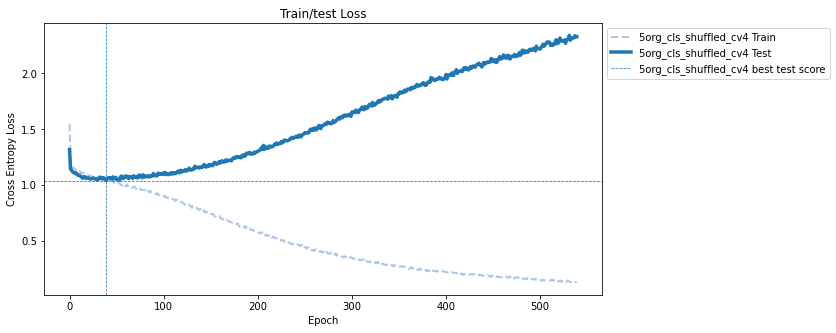

Running predictions for 5org_cls_shuffled_cv4


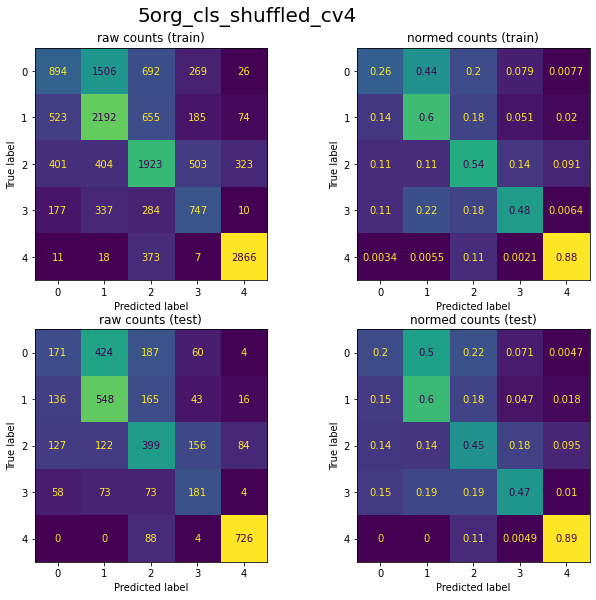

In [8]:
target_col = 'id'
seq_col = 'shuffled_seq'

# for each cv
for i in [0,1,2,3,4]:
    print(f"___Running CV{i}___")
    train_df = pd.read_csv(f'data/5org_ups_cls_splits/cv{i}_train.tsv',sep='\t')
    test_df = pd.read_csv(f'data/5org_ups_cls_splits/cv{i}_test.tsv',sep='\t')
    seq_len = len(train_df[seq_col].values[0])
    
    # sequences to predict on after training
    seq_list = [
        (train_df[seq_col].values,train_df[target_col],"train"),
        (test_df[seq_col].values,test_df[target_col],"test")
    ]

    # create data loaders
    sampler = tu.make_weighted_sampler(train_df,target_col)
    
    dataset_types = [
        DatasetSpec('ohe'),
    ]

    dls = tu.build_dataloaders(
                    train_df, 
                    test_df, 
                    dataset_types, # just OHE for now
                    seq_col=seq_col,
                    target_col=target_col,
                    sampler=sampler,
                    shuffle=False,
                )
    ohe_train_dl,ohe_val_dl = dls['ohe']
    
    m_args = (seq_len,5)
    m_kwargs = {
        "num_filters1":32,
        "num_filters2":32,
        "kernel_size1":10,
        "kernel_size2":6,
        "conv_pool_size1":2,
        "fc_node_num1":50,
        "fc_node_num2":50,
        "dropout1":0.25
    }
    
    model = m.DNA_2CNN_2FC(*m_args,**m_kwargs)
    model_name = f"5org_cls_shuffled_cv{i}"

    # +-------------+
    # | TRAIN MODEL |
    # +-------------+
    t_res = tu.collect_model_stats(
        model_name,
        seq_len,
        ohe_train_dl,
        ohe_val_dl,
        DEVICE,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model,
        loss_type='classification'
    )

    model_res[model_name] = t_res
    
    # +------------+
    # | EVAL MODEL |
    # +------------+
    p_res_df = tu.get_confusion_stats(
        t_res['model'],
        t_res['model_name'],
        seq_list,
        DEVICE,
        title=f"{t_res['model_name']}",
    )
    
    p_res_df['model_type'] = "CNN"
    p_res_df['seq_mode'] = "shuffled"
    p_res_df['fold'] = i # which cv split
    p_res_df['task'] = '5org_cls'
    p_res_df['best_val_score'] = t_res['best_val_score']
    p_res_df['epoch_stop'] = t_res['epoch_stop']
    p_res_df['total_time'] = t_res['total_time']
    
    pred_dfs[model_name] = p_res_df
    
    
    
    

In [9]:
all_preds = pd.concat([pred_dfs[x] for x in pred_dfs])
all_preds

,model_name,split,mac_precision,mac_recall,mac_f1,support,model_type,seq_mode,fold,task,best_val_score,epoch_stop,total_time
0,5org_cls_cv0,train,0.967217,0.967753,0.967459,15399,CNN,regular,0,5org_cls,0.429880,213,467.854789
1,5org_cls_cv0,test,0.859443,0.857226,0.858271,3850,CNN,regular,0,5org_cls,0.429880,213,467.854789
0,5org_cls_cv1,train,0.963829,0.963482,0.963362,15399,CNN,regular,1,5org_cls,0.437770,179,443.103833
1,5org_cls_cv1,test,0.861012,0.859076,0.859932,3850,CNN,regular,1,5org_cls,0.437770,179,443.103833
0,5org_cls_cv2,train,0.974937,0.974692,0.974719,15399,CNN,regular,2,5org_cls,0.426750,186,451.542392
1,5org_cls_cv2,test,0.861398,0.853761,0.856973,3850,CNN,regular,2,5org_cls,0.426750,186,451.542392
0,5org_cls_cv3,train,0.967191,0.968576,0.967842,15399,CNN,regular,3,5org_cls,0.438126,196,457.810494
1,5org_cls_cv3,test,0.851454,0.848208,0.849668,3850,CNN,regular,3,5org_cls,0.438126,196,457.810494
0,5org_cls_cv4,train,0.973206,0.973160,0.973101,15400,CNN,regular,4,5org_cls,0.427027,189,454.584272
1,5org_cls_cv4,test,0.860758,0.857180,0.858302,3849,CNN,regular,4,5org_cls,0.427027,189,454.584272


In [10]:
def plot_macf1(df):
    sns.barplot(data=df,y='model_name',x='mac_f1',hue='split',dodge=True)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.xlabel("Macro F1 score",fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel("")
    plt.yticks(fontsize=14)
    plt.show()

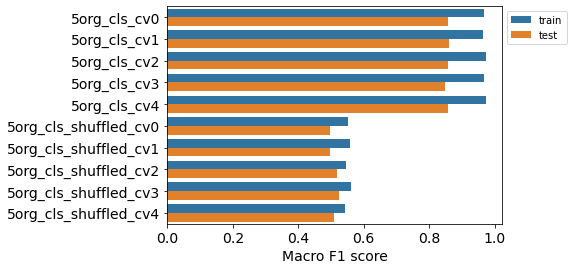

In [11]:
plot_macf1(all_preds)

In [12]:
df_train = all_preds[all_preds['split']=='train']
df_test = all_preds[all_preds['split']=='test']

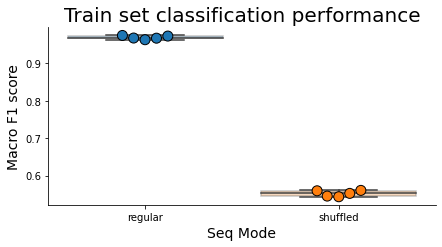

In [13]:
g = sns.catplot(
    data=df_train, x='seq_mode', y='mac_f1',
    kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='mac_f1',
                size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Train set classification performance",fontsize=20)
plt.show()

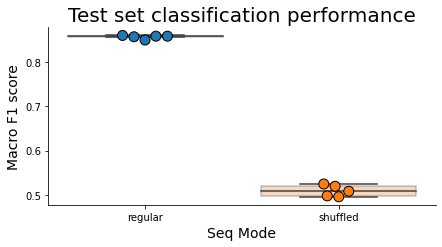

In [14]:
g = sns.catplot(
    data=df_test, x='seq_mode', y='mac_f1',
    kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='mac_f1',
                size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Test set classification performance",fontsize=20)
plt.show()

In [15]:
from scipy.stats import ttest_ind

In [16]:
regular_scores = df_test[df_test['seq_mode']=='regular']['mac_f1'].values
shuffled_scores = df_test[df_test['seq_mode']=='shuffled']['mac_f1'].values
print("T-test:",ttest_ind(regular_scores, shuffled_scores))
print()
print("Mean Mac F1 for regular seqs:",np.mean(regular_scores))
print("Mean Mac F1 for shuffled seqs:",np.mean(shuffled_scores))

T-test: Ttest_indResult(statistic=58.09292389040087, pvalue=8.561113168196009e-12)

Mean Mac F1 for regular seqs: 0.8566294615549037
Mean Mac F1 for shuffled seqs: 0.509050595171266


In [ ]:
# Check summary from these 5 runs
# If they look good, proceed with Split 0 as a representative model

In [3]:
train_df = pd.read_csv(f'data/5org_cls_splits/cv0_train.tsv',sep='\t').fillna("")
test_df = pd.read_csv(f'data/5org_cls_splits/cv0_test.tsv',sep='\t').fillna("")

In [4]:
train_df['shuffled_seq'] = train_df['upstream_region'].apply(lambda x: u.shuffle_seq(x))
test_df['shuffled_seq'] = test_df['upstream_region'].apply(lambda x: u.shuffle_seq(x))

In [6]:
seq_len = len(train_df['upstream_region'].values[0])
sampler = tu.make_weighted_sampler(train_df,'id')

dataset_types = [
    DatasetSpec('ohe'),
]

dls = tu.build_dataloaders(
                train_df, 
                test_df, 
                dataset_types, # just OHE for now
                seq_col='upstream_region',
                target_col='id',
                sampler=sampler,
                shuffle=False,
            )
ohe_train_dl,ohe_val_dl = dls['ohe']

In [7]:
model_res = {}
pred_dfs = {}


In [9]:
# # Define the models
# model = m.DNA_2CNN_2FC(
#             seq_len,
#             5, # num tasks
#             num_filters1=32,
#             num_filters2=32,
#             kernel_size1=10,
#             kernel_size2=6,
#             conv_pool_size1=2,
#             fc_node_num1=50,
#             fc_node_num2=50,
#             dropout1=0.25
#         )

In [8]:
m_args = (seq_len,5)
m_kwargs = {
    "num_filters1":32,
    "num_filters2":32,
    "kernel_size1":10,
    "kernel_size2":6,
    "conv_pool_size1":2,
    "fc_node_num1":50,
    "fc_node_num2":50,
    "dropout1":0.25
}

model = m.DNA_2CNN_2FC(*m_args,**m_kwargs)

In [9]:
cnn_name = "5org_cls_cnn"

model_res[cnn_name] = tu.collect_model_stats(
    cnn_name,
    seq_len,
    ohe_train_dl,
    ohe_val_dl,
    DEVICE,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model,
    loss_type='classification'
)

E:276 | train loss:0.116 | val loss: 0.544:   6%|▌         | 277/5000 [03:02<51:14,  1.54it/s]

EarlyStopping counter: 125 out of 500


E:349 | train loss:0.080 | val loss: 0.597:   7%|▋         | 350/5000 [03:50<50:59,  1.52it/s]


KeyboardInterrupt: 

In [ ]:
# confusion matrix plotting
seq_list = [
    (train_df["upstream_region"].values,train_df["id"],"train"),
    (test_df["upstream_region"].values,test_df["id"],"test")
]
pred_dfs[cnn_name] = tu.get_confusion_stats(
    model_res[cnn_name]['model'],
    model_res[cnn_name]['model_name'],
    seq_list,
    DEVICE,
    title=f"{model_res[cnn_name]['model_name']}"
)

pred_dfs[cnn_name]

Without much adjusting, this model arch works well for predicting the origin species of each upstream region

# Look at model filters

Total convolutional layers: 2
Num filters 32
filt_width 10
Seq 0 of 3850
Seq 100 of 3850
Seq 200 of 3850
Seq 300 of 3850
Seq 400 of 3850
Seq 500 of 3850
Seq 600 of 3850
Seq 700 of 3850
Seq 800 of 3850
Seq 900 of 3850
Seq 1000 of 3850
Seq 1100 of 3850
Seq 1200 of 3850
Seq 1300 of 3850
Seq 1400 of 3850
Seq 1500 of 3850
Seq 1600 of 3850
Seq 1700 of 3850
Seq 1800 of 3850
Seq 1900 of 3850
Seq 2000 of 3850
Seq 2100 of 3850
Seq 2200 of 3850
Seq 2300 of 3850
Seq 2400 of 3850
Seq 2500 of 3850
Seq 2600 of 3850
Seq 2700 of 3850
Seq 2800 of 3850
Seq 2900 of 3850
Seq 3000 of 3850
Seq 3100 of 3850
Seq 3200 of 3850
Seq 3300 of 3850
Seq 3400 of 3850
Seq 3500 of 3850
Seq 3600 of 3850
Seq 3700 of 3850
Seq 3800 of 3850
torch.Size([32, 4, 10])


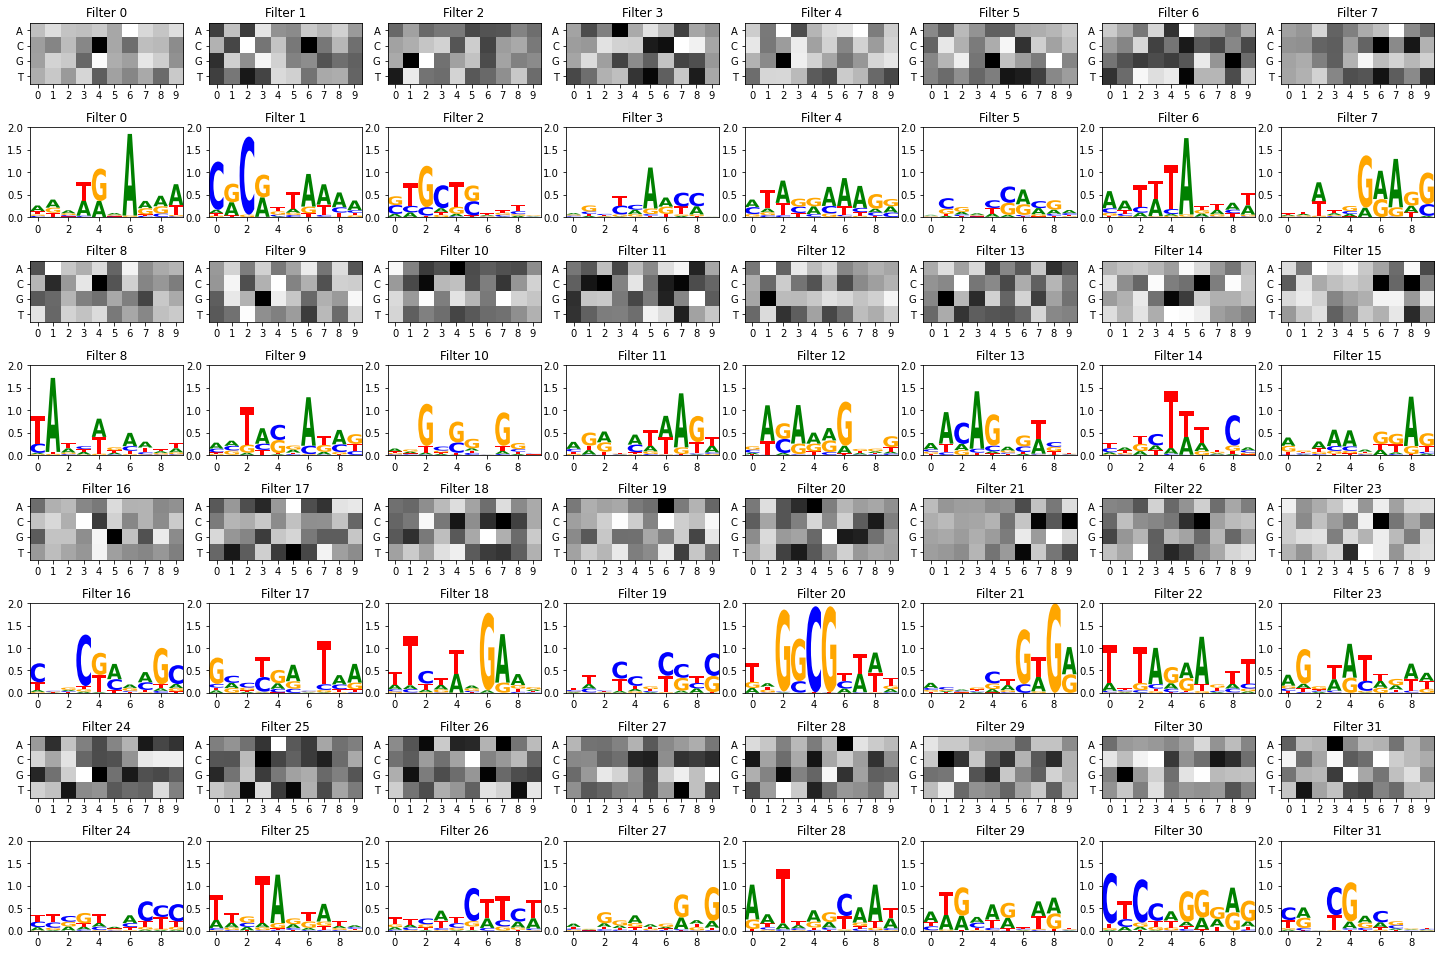

In [24]:
# Check filters of Model 
model = model_res['5org_cls_cnn']['model']
seqs = test_df['upstream_region'].values
v.view_conv2D_wrapper(model,seqs,DEVICE,act_thresh=0.5,ysc=0.75)

## Train on shuffled seqs

In [19]:
shuff_dls = tu.build_dataloaders(
                train_df, 
                test_df, 
                dataset_types, # just OHE for now
                seq_col='shuffled_seq',
                target_col='id',
                sampler=sampler,
                shuffle=False,
            )
shuff_ohe_train_dl,shuff_ohe_val_dl = shuff_dls['ohe']

E:144 | train loss:0.366 | val loss: 1.737:   3%|▎         | 145/5000 [01:38<54:29,  1.49it/s]

EarlyStopping counter: 125 out of 500


E:269 | train loss:0.177 | val loss: 2.342:   5%|▌         | 270/5000 [03:02<52:58,  1.49it/s]

EarlyStopping counter: 250 out of 500


E:394 | train loss:0.114 | val loss: 2.661:   8%|▊         | 395/5000 [04:27<52:03,  1.47it/s]

EarlyStopping counter: 375 out of 500


E:519 | train loss:0.081 | val loss: 2.955:  10%|█         | 519/5000 [05:51<50:39,  1.47it/s]

EarlyStopping counter: 500 out of 500
Early stopping


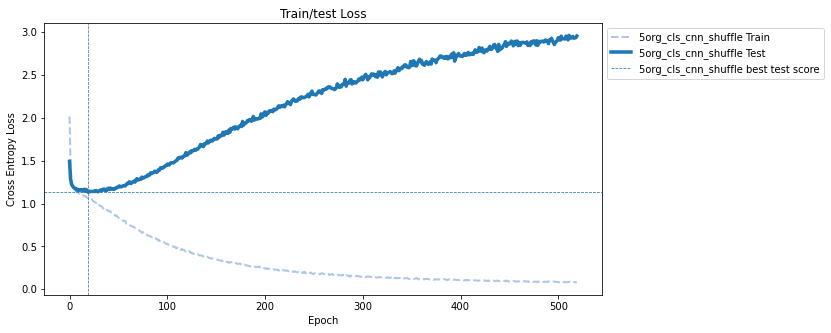

Running predictions for 5org_cls_cnn_shuffle


,model_name,split,mac_precision,mac_recall,mac_f1,support
0,5org_cls_cnn_shuffle,train,0.531344,0.550443,0.537671,15399
1,5org_cls_cnn_shuffle,test,0.472806,0.487557,0.477383,3850


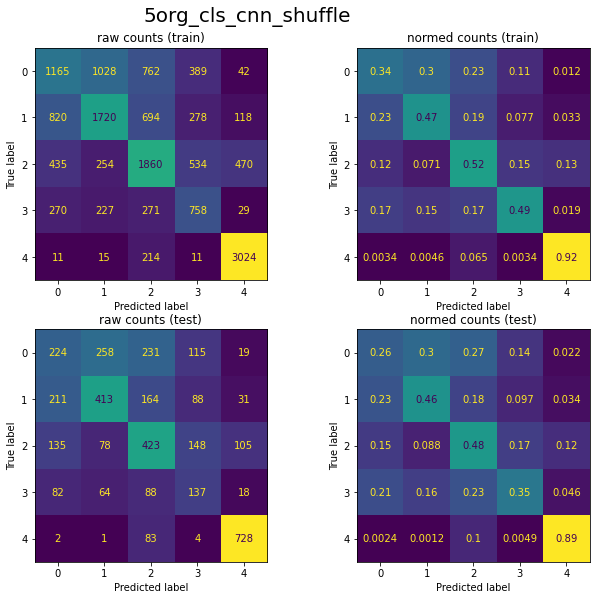

In [20]:
cnn_name = "5org_cls_cnn_shuffle"

model_res[cnn_name] = tu.collect_model_stats(
    cnn_name,
    seq_len,
    shuff_ohe_train_dl,
    shuff_ohe_val_dl,
    DEVICE,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model,
    loss_type='classification'
)

# confusion matrix plotting
shuff_seq_list = [
    (train_df["shuffled_seq"].values,train_df["id"],"train"),
    (test_df["shuffled_seq"].values,test_df["id"],"test")
]
pred_dfs[cnn_name] = tu.get_confusion_stats(
    model_res[cnn_name]['model'],
    model_res[cnn_name]['model_name'],
    shuff_seq_list,
    DEVICE,
    title=f"{model_res[cnn_name]['model_name']}"
)

pred_dfs[cnn_name]

### Compare Macro F1

In [21]:
all_preds = pd.concat([pred_dfs[x] for x in pred_dfs])
all_preds

,model_name,split,mac_precision,mac_recall,mac_f1,support
0,5org_cls_cnn,train,0.975907,0.976549,0.976219,15399
1,5org_cls_cnn,test,0.858366,0.854585,0.856229,3850
0,reloaded saved CNN,train,0.975907,0.976549,0.976219,15399
1,reloaded saved CNN,test,0.858366,0.854585,0.856229,3850
0,5org_cls_cnn_shuffle,train,0.531344,0.550443,0.537671,15399
1,5org_cls_cnn_shuffle,test,0.472806,0.487557,0.477383,3850


In [22]:
def plot_macf1(df):
    sns.barplot(data=df,y='model_name',x='mac_f1',hue='split',dodge=True)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.xlabel("Macro F1 score",fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel("")
    plt.yticks(fontsize=14)
    plt.show()

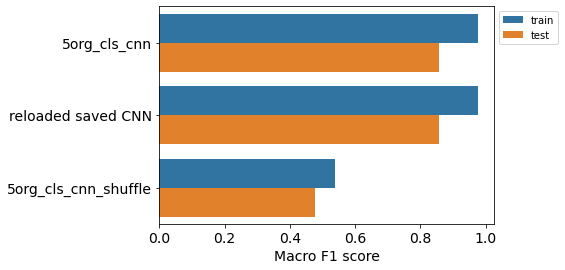

In [23]:
plot_macf1(all_preds)

# Save the 5org classification model

In [25]:
model = model_res['5org_cls_cnn']['model']
opt = model_res['5org_cls_cnn']['opt']

for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in opt.state_dict():
    print(var_name, "\t", opt.state_dict()[var_name])

conv_net.0.weight 	 torch.Size([32, 1, 4, 10])
conv_net.0.bias 	 torch.Size([32])
conv_net.4.weight 	 torch.Size([32, 32, 1, 6])
conv_net.4.bias 	 torch.Size([32])
conv_net.8.weight 	 torch.Size([50, 4480])
conv_net.8.bias 	 torch.Size([50])
conv_net.10.weight 	 torch.Size([50, 50])
conv_net.10.bias 	 torch.Size([50])
conv_net.12.weight 	 torch.Size([5, 50])
conv_net.12.bias 	 torch.Size([5])
Optimizer's state_dict:
state 	 {139760971219984: {'step': 81796, 'exp_avg': tensor([[[[-2.9144e-03, -5.6363e-04, -1.1668e-04,  ..., -5.0754e-03,
            6.9519e-04, -2.3672e-03],
          [-5.8266e-04, -2.5218e-03, -3.2648e-03,  ..., -1.3737e-03,
            7.3594e-04, -2.9469e-03],
          [-2.8656e-03, -1.3455e-04, -2.7094e-03,  ..., -2.1799e-03,
           -5.4318e-03, -2.2152e-03],
          [ 1.8539e-03, -1.2887e-03,  1.5823e-03,  ...,  4.1204e-03,
           -5.0803e-04,  3.0206e-03]]],


        [[[ 9.5683e-04, -7.0018e-03,  7.9089e-04,  ...,  2.9687e-03,
            1.3301e-03, -2

In [16]:
torch.save(model.state_dict(),'saved_models/5org_cls_cv0_model_state_dict.pt')
torch.save(opt.state_dict(),'saved_models/5org_cls_cv0_opt_state_dict.pt')

In [37]:
# WHOLE_PATH='saved_models/5org_cls_cv0_ALL.tar'

# torch.save({
#             'epoch': t_res['epoch_stop'],
#             'model_state_dict': t_res['model'].state_dict(),
#             'opt_state_dict': t_res['opt'].state_dict(),
#             'loss': t_res['best_val_score'],
#             }, WHOLE_PATH)

In [26]:
# RELOAD MODEL
model_re = m.DNA_2CNN_2FC(*m_args,**m_kwargs)
model_re.load_state_dict(torch.load('saved_models/5org_cls_cv0_model_state_dict.pt'))

<All keys matched successfully>

Running predictions for reloaded saved CNN


,model_name,split,mac_precision,mac_recall,mac_f1,support
0,reloaded saved CNN,train,0.975907,0.976549,0.976219,15399
1,reloaded saved CNN,test,0.858366,0.854585,0.856229,3850


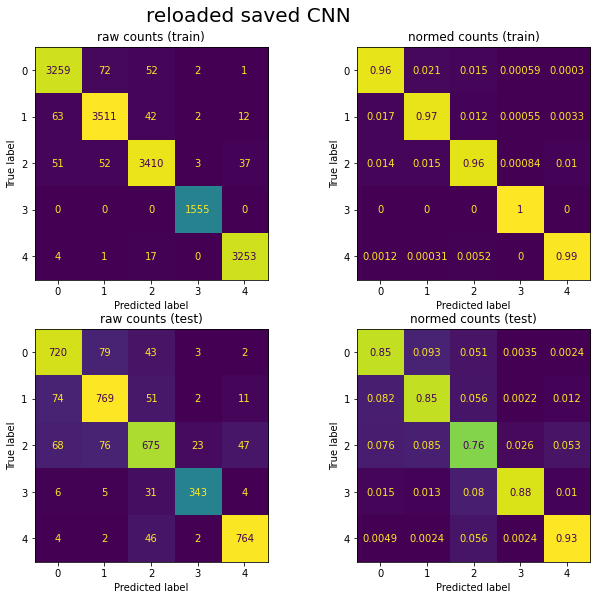

In [27]:
# confusion matrix plotting
pred_dfs["reloaded saved CNN"] = tu.get_confusion_stats(
    model_re.to(DEVICE),
    "reloaded saved CNN",
    seq_list,
    DEVICE,
    title=f"reloaded saved CNN"
)

pred_dfs["reloaded saved CNN"]

# Warm start model from saved state dict

In [33]:
model_re

DNA_2CNN_2FC(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 10), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 6), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten()
    (8): Linear(in_features=4480, out_features=50, bias=True)
    (9): ReLU()
    (10): Linear(in_features=50, out_features=50, bias=True)
    (11): ReLU()
    (12): Linear(in_features=50, out_features=5, bias=True)
  )
)

In [34]:
model_re.state_dict().keys()

odict_keys(['conv_net.0.weight', 'conv_net.0.bias', 'conv_net.4.weight', 'conv_net.4.bias', 'conv_net.8.weight', 'conv_net.8.bias', 'conv_net.10.weight', 'conv_net.10.bias', 'conv_net.12.weight', 'conv_net.12.bias'])

In [43]:
def see_model_layers(model):
    extracted_layers = {k: v for k, v in model.state_dict().items()}
    extracted_layers_shapes = [(k,extracted_layers[k].shape) for k in extracted_layers]
    for x in extracted_layers_shapes:
        print(x)

In [44]:
see_model_layers(model_re)

('conv_net.0.weight', torch.Size([32, 1, 4, 10]))
('conv_net.0.bias', torch.Size([32]))
('conv_net.4.weight', torch.Size([32, 32, 1, 6]))
('conv_net.4.bias', torch.Size([32]))
('conv_net.8.weight', torch.Size([50, 4480]))
('conv_net.8.bias', torch.Size([50]))
('conv_net.10.weight', torch.Size([50, 50]))
('conv_net.10.bias', torch.Size([50]))
('conv_net.12.weight', torch.Size([5, 50]))
('conv_net.12.bias', torch.Size([5]))


### Remove the weight and bias from the final layer, so we can change the prediciton task

In [45]:
# Exclude final layer of model.state_dict certain 
to_exclude = ['conv_net.12.weight', 'conv_net.12.bias']
weights_to_keep = {k: v for k, v in model_re.state_dict().items() if k not in to_exclude}
weights_to_keep.keys()

dict_keys(['conv_net.0.weight', 'conv_net.0.bias', 'conv_net.4.weight', 'conv_net.4.bias', 'conv_net.8.weight', 'conv_net.8.bias', 'conv_net.10.weight', 'conv_net.10.bias'])

In [46]:
model_warm = m.DNA_2CNN_2FC(seq_len, 3,**m_kwargs)
model_warm.load_state_dict(weights_to_keep,strict=False)

_IncompatibleKeys(missing_keys=['conv_net.12.weight', 'conv_net.12.bias'], unexpected_keys=[])

In [47]:
model_warm

DNA_2CNN_2FC(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 10), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 6), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten()
    (8): Linear(in_features=4480, out_features=50, bias=True)
    (9): ReLU()
    (10): Linear(in_features=50, out_features=50, bias=True)
    (11): ReLU()
    (12): Linear(in_features=50, out_features=3, bias=True)
  )
)

# Try training a warm model for a different task

In [48]:
locus_info_filename = 'data/locus2info_20221031.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t')
locus2info = u.make_info_dict(locus_info_df)

#data_filename = "data/XY_logTPM_opFilt_20221031.tsv"
data_filename = "data/XY_lr_noCu_opFilt_20221031.tsv"
XYdf_og = pd.read_csv(data_filename,sep='\t')
XYdf_og['gene'] = XYdf_og['locus_tag'].apply(lambda x: locus2info[x]['gene'])
XYdf_og['product'] = XYdf_og['locus_tag'].apply(lambda x: locus2info[x]['product'])
XYdf_og['type'] = XYdf_og['locus_tag'].apply(lambda x: locus2info[x]['type'])

XYdf_og

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,...,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,gene,product,type
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.333441,-0.087509,-0.248330,-0.654293,0.0,0.252788,0.260753,...,-0.117634,-0.180709,-0.516711,-0.472602,0.058102,0.668619,0.215153,dnaA,chromosomal replication initiator protein DnaA,CDS
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.179318,-0.183682,-0.493245,-1.323530,0.0,0.418315,0.611021,...,-0.244793,-0.161434,0.237179,-0.079076,0.132689,-0.462317,-0.490073,dnaN,DNA polymerase III subunit beta,CDS
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.364849,0.170159,-0.338861,-0.347147,0.0,0.287824,0.387577,...,-0.249011,-0.066333,-0.987336,-0.990306,0.481623,0.144467,-0.239513,recF,DNA replication/repair protein RecF,CDS
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,0.193539,0.035923,0.136026,-0.642058,0.0,0.189394,0.345084,...,0.643283,0.566397,-0.952383,-0.465515,0.009531,0.367039,0.695145,NaN,hypothetical protein,CDS
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.173256,0.283822,-0.740565,-1.011908,0.0,0.215938,0.306791,...,0.539188,0.622656,-0.716034,-0.025042,0.070784,-0.367242,-0.319915,NaN,bifunctional diguanylate cyclase/phosphodieste...,CDS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.620221,0.718300,0.245892,-1.598809,0.0,0.171579,0.501296,...,0.977712,1.564370,0.701928,1.577361,0.777911,0.463434,0.727701,hxlA,3-hexulose-6-phosphate synthase,CDS
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.609995,0.702416,0.231606,-1.614646,0.0,0.154029,0.483579,...,0.952955,1.548383,0.701457,1.573150,0.761210,0.433925,0.705205,hxlA,3-hexulose-6-phosphate synthase,CDS
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,0.605448,0.688065,0.233752,-1.594922,0.0,0.171939,0.486032,...,0.899683,1.442487,0.708730,1.520411,0.769644,0.032260,0.305817,hxlA,3-hexulose-6-phosphate synthase,CDS
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,0.604488,0.196871,-0.261330,0.125607,0.0,-0.014653,0.229101,...,-0.233161,0.107133,0.265191,-0.870372,0.814080,-0.245552,-0.285502,NaN,transposase,CDS


In [54]:
tu.set_reg_class_up_down(XYdf_og,'highCu',thresh=0.6)
XYdf_og['highCu_reg_UD'].value_counts()

1    1957
2     159
0      95
Name: highCu_reg_UD, dtype: int64

In [55]:
# get TPM df to filter out non-expressing genes
data_filename = "data/XY_TPM_opFilt_20221031.tsv"
tpm_df = pd.read_csv(data_filename,sep='\t')
tpm_df

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,44.589239,33.305149,29.791989,22.484978,35.387855,42.164887,42.398329,36.574762,62.642333,30.485060,32.616911,31.221609,24.734827,25.502734,36.842130,56.250801,41.079168
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,51.646261,40.157361,32.402422,18.223699,45.609876,60.951472,69.661793,51.522053,95.745624,41.526462,38.491860,40.781423,53.759707,43.177206,50.003709,33.104545,32.473733
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,29.102185,25.428342,17.868485,17.766155,22.599309,27.589182,29.564291,24.013022,43.385614,20.311406,19.016705,21.583752,11.399278,11.375836,31.555718,24.979519,19.142317
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,75.378027,67.576797,72.432184,42.238158,65.914934,75.161805,83.726814,67.429437,94.526584,55.016260,102.951158,97.608173,34.063390,47.736427,66.351841,85.010678,106.719351
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,23.475112,25.344937,12.460055,10.323755,20.818638,24.179988,25.751687,21.777752,18.879559,21.903063,30.252690,32.054614,12.673738,20.460387,21.865558,16.139920,16.678171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,2414.351803,2584.195759,1862.586567,518.568549,1570.708136,1769.073837,2223.313532,1579.606430,1204.757230,4261.953435,3093.257534,4645.343725,2555.034515,4687.360578,2693.209622,2165.722951,2601.090142
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,2419.134023,2579.178379,1861.029495,517.578238,1585.013725,1763.601177,2216.179330,1578.753812,1222.646543,4246.905233,3068.323264,4635.992387,2577.463359,4716.267599,2686.458439,2141.201715,2584.168594
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,2427.383179,2570.446233,1876.060099,528.154680,1595.439950,1797.376818,2234.552551,1612.522000,1275.901815,4230.257160,2976.542208,4336.229765,2607.531550,4576.881691,2719.984378,1631.517103,1972.152368
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,51.530064,38.846844,28.276361,36.974559,33.891568,33.549091,39.724451,29.848200,37.808647,28.096495,28.833893,36.504131,40.730731,18.538883,59.587377,28.587290,27.806550


In [57]:
with open("data/conditions_to_include_20221031.txt",'r') as f:
    conds = [x.strip() for x in f.readlines()]
    
conds

['uMax',
 'lowO2_fast_growth',
 'lowCH4',
 'MeOH',
 'NoCu',
 'medCu',
 'highCu',
 'lowCu',
 'highO2_slow_growth',
 'NO3_lowO2_slow_growth',
 'WithLanthanum',
 'NoLanthanum',
 'LanzaTech',
 'aa3_KO',
 'crotonic_acid',
 'CH4_500ppm',
 'CH4_1000ppm']

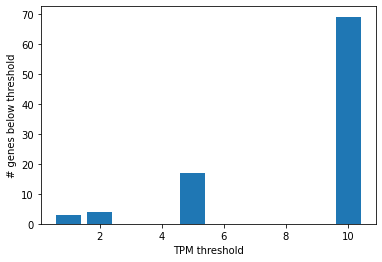

In [58]:
no_tx_genes1 = []
no_tx_genes2 = []
no_tx_genes5 = []
no_tx_genes10 = []
for i, row, in tpm_df.iterrows():
    tpms = row[conds].values
    if max(tpms) < 1.0:
        no_tx_genes1.append(row['locus_tag'])
    if max(tpms) < 2.0:
        no_tx_genes2.append(row['locus_tag'])
    if max(tpms) < 5.0:
        no_tx_genes5.append(row['locus_tag'])
    if max(tpms) < 10.0:
        no_tx_genes10.append(row['locus_tag'])

plt.bar([1,2,5,10],[len(no_tx_genes1),len(no_tx_genes2),len(no_tx_genes5),len(no_tx_genes10)])
plt.xlabel("TPM threshold")
plt.ylabel("# genes below threshold")
plt.show()

In [62]:
# There are some lowly expressing genes (never expression above 5TPM)
# that end up in the Up and Down groups... let's remove
XYdf_og[XYdf_og['locus_tag'].isin(no_tx_genes5)].sort_values('highCu')[['locus_tag','product','highCu','highCu_reg_UD']]

,locus_tag,product,highCu,highCu_reg_UD
1072,EQU24_RS11380,IS66 family transposase,-2.110366,0
861,EQU24_RS09050,IS66 family transposase,-2.010145,0
1559,EQU24_RS16370,helix-turn-helix domain-containing protein,-0.668370,0
1871,EQU24_RS19655,IS66 family transposase,-0.595065,1
2195,EQU24_RS23040,hypothetical protein,-0.486623,1
116,EQU24_RS01215,IS66 family transposase,-0.459513,1
2138,EQU24_RS22355,hypothetical protein,-0.453829,1
719,EQU24_RS07485,IS66 family transposase,0.000000,1
2191,EQU24_RS23000,hypothetical protein,0.000000,1
1959,EQU24_RS20685,AAA family ATPase,0.039976,1


In [64]:
# XYdf is filtered for genes that express above 5TPM in at least 1 condition
XYdf = XYdf_og[~XYdf_og['locus_tag'].isin(no_tx_genes5)].reset_index().drop('index',axis=1)
XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,...,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,gene,product,type,highCu_reg_UD
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.333441,-0.087509,-0.248330,-0.654293,0.0,0.252788,0.260753,...,-0.180709,-0.516711,-0.472602,0.058102,0.668619,0.215153,dnaA,chromosomal replication initiator protein DnaA,CDS,1
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.179318,-0.183682,-0.493245,-1.323530,0.0,0.418315,0.611021,...,-0.161434,0.237179,-0.079076,0.132689,-0.462317,-0.490073,dnaN,DNA polymerase III subunit beta,CDS,2
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.364849,0.170159,-0.338861,-0.347147,0.0,0.287824,0.387577,...,-0.066333,-0.987336,-0.990306,0.481623,0.144467,-0.239513,recF,DNA replication/repair protein RecF,CDS,1
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,0.193539,0.035923,0.136026,-0.642058,0.0,0.189394,0.345084,...,0.566397,-0.952383,-0.465515,0.009531,0.367039,0.695145,NaN,hypothetical protein,CDS,1
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.173256,0.283822,-0.740565,-1.011908,0.0,0.215938,0.306791,...,0.622656,-0.716034,-0.025042,0.070784,-0.367242,-0.319915,NaN,bifunctional diguanylate cyclase/phosphodieste...,CDS,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2189,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.620221,0.718300,0.245892,-1.598809,0.0,0.171579,0.501296,...,1.564370,0.701928,1.577361,0.777911,0.463434,0.727701,hxlA,3-hexulose-6-phosphate synthase,CDS,1
2190,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.609995,0.702416,0.231606,-1.614646,0.0,0.154029,0.483579,...,1.548383,0.701457,1.573150,0.761210,0.433925,0.705205,hxlA,3-hexulose-6-phosphate synthase,CDS,1
2191,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,0.605448,0.688065,0.233752,-1.594922,0.0,0.171939,0.486032,...,1.442487,0.708730,1.520411,0.769644,0.032260,0.305817,hxlA,3-hexulose-6-phosphate synthase,CDS,1
2192,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,0.604488,0.196871,-0.261330,0.125607,0.0,-0.014653,0.229101,...,0.107133,0.265191,-0.870372,0.814080,-0.245552,-0.285502,NaN,transposase,CDS,1


In [49]:
# wt_df = XYdf_og[['locus_tag','upstream_region']]
# fake_df = XYdf_og[['locus_tag','upstream_region']]
# fake_df['upstream_region'] = fake_df['upstream_region'].apply(lambda x: shuffle_seq(x))
# fake_df

In [50]:
# wt_df['id'] = 0
# fake_df['id']=1

In [51]:
# wtshuff_df = pd.concat([wt_df,fake_df])
# wtshuff_df

In [65]:
from sklearn.model_selection import StratifiedKFold 
skf = StratifiedKFold(n_splits=5)


In [71]:
# Make K fold splits
def make_kfold_splits(df, target_col, id_col,splitter,outdir):
    for i, (train_idxs, test_idxs) in enumerate(splitter.split(df, df[target_col])):
        print(f"_____Split {i}____")
        train_df = df.iloc[train_idxs]
        test_df = df.iloc[test_idxs]

        #v.plot_train_test_hist(train_df, test_df,score_col=target_col,bins=200)
        v.view_train_test_dist(train_df, test_df,[target_col],id_col=id_col)
        print("TRAIN")
        print(train_df[target_col].value_counts())
        print("TEST")
        print(test_df[target_col].value_counts())
        print("")

        train_df.to_csv(f'data/{outdir}/cv{i}_train.tsv',index=False,sep='\t')
        test_df.to_csv(f'data/{outdir}/cv{i}_test.tsv',index=False,sep='\t')


_____Split 0____


/home/ubuntu/workspace/mbur-sequence-learning/viz.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


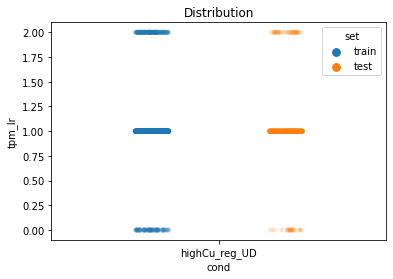

TRAIN
1    1556
2     125
0      74
Name: highCu_reg_UD, dtype: int64
TEST
1    390
2     31
0     18
Name: highCu_reg_UD, dtype: int64

_____Split 1____


/home/ubuntu/workspace/mbur-sequence-learning/viz.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


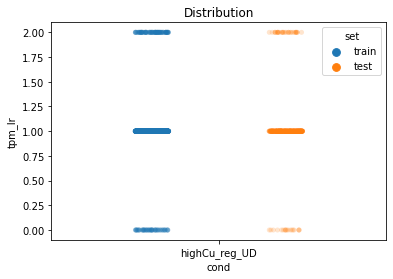

TRAIN
1    1557
2     124
0      74
Name: highCu_reg_UD, dtype: int64
TEST
1    389
2     32
0     18
Name: highCu_reg_UD, dtype: int64

_____Split 2____


/home/ubuntu/workspace/mbur-sequence-learning/viz.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


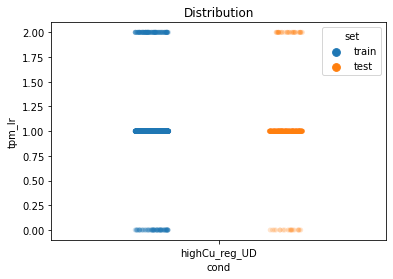

TRAIN
1    1557
2     125
0      73
Name: highCu_reg_UD, dtype: int64
TEST
1    389
2     31
0     19
Name: highCu_reg_UD, dtype: int64

_____Split 3____


/home/ubuntu/workspace/mbur-sequence-learning/viz.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


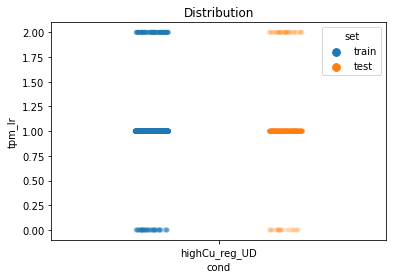

TRAIN
1    1557
2     125
0      73
Name: highCu_reg_UD, dtype: int64
TEST
1    389
2     31
0     19
Name: highCu_reg_UD, dtype: int64

_____Split 4____


/home/ubuntu/workspace/mbur-sequence-learning/viz.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


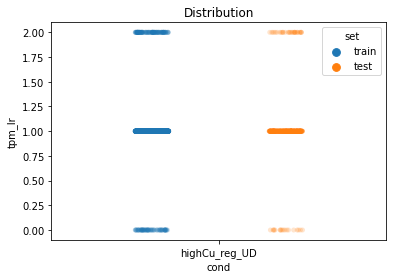

TRAIN
1    1557
2     125
0      74
Name: highCu_reg_UD, dtype: int64
TEST
1    389
2     31
0     18
Name: highCu_reg_UD, dtype: int64



In [72]:
target_col = 'highCu_reg_UD'
id_col = 'locus_tag'
outdir = 'highCu_cls_splits'
make_kfold_splits(XYdf,target_col, id_col,skf, outdir)

In [41]:
dataset_types = [
    DatasetSpec('ohe'),
]

wts_dls = tu.build_dataloaders_single(
                wts_train_df, 
                wts_test_df, 
                dataset_types, # just OHE for now
                seq_col='upstream_region',
                target_col='id',
                sampler=None,
                shuffle=True,
            )
wts_ohe_train_dl,wts_ohe_val_dl = wts_dls['ohe']

E:215 | train loss:0.035 | val loss: 0.248:   4%|▍         | 216/5000 [00:33<12:09,  6.56it/s]

EarlyStopping counter: 125 out of 500


E:340 | train loss:0.016 | val loss: 0.291:   7%|▋         | 341/5000 [00:52<11:47,  6.58it/s]

EarlyStopping counter: 250 out of 500


E:465 | train loss:0.013 | val loss: 0.330:   9%|▉         | 466/5000 [01:11<11:22,  6.64it/s]

EarlyStopping counter: 375 out of 500


E:589 | train loss:0.006 | val loss: 0.341:  12%|█▏        | 589/5000 [01:30<11:19,  6.50it/s]


EarlyStopping counter: 500 out of 500
Early stopping


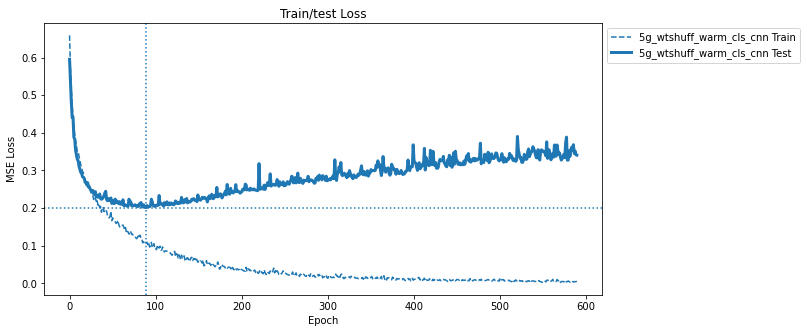

In [42]:
cnn2_name = "5g_wtshuff_warm_cls_cnn"

model_res[cnn2_name] = collect_model_stats(
    cnn2_name,
    seq_len,
    wts_ohe_train_dl,
    wts_ohe_val_dl,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model4,
)

Running warm model, new task, 2 heads


,model_name,split,mac_precision,mac_recall,mac_f1,support
0,"warm model, new task, 2 heads",train,0.990956,0.990955,0.990955,3538
1,"warm model, new task, 2 heads",test,0.925557,0.925339,0.925330,884


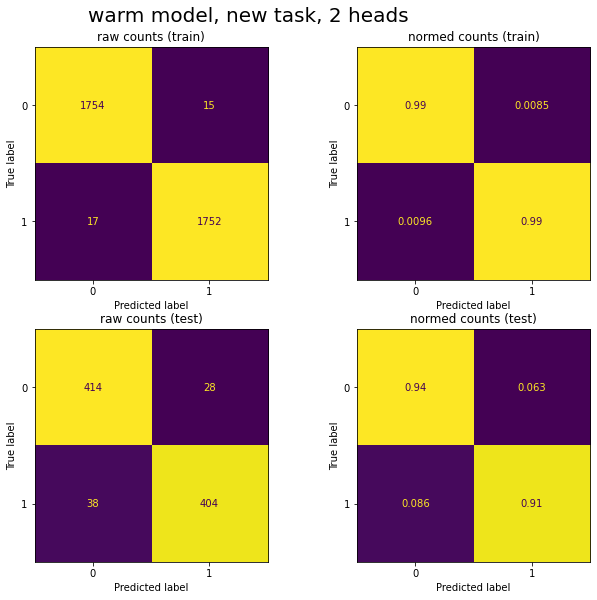

In [44]:
# confusion matrix plotting
seq_list = [
    (wts_train_df["upstream_region"].values,wts_train_df["id"],"train"),
    (wts_test_df["upstream_region"].values,wts_test_df["id"],"test")
]
pred_dfs["warm model, new task, 2 heads"] = get_confusion_stats(
    model4.to(DEVICE),
    "warm model, new task, 2 heads",
    seq_list,
    title=f"warm model, new task, 2 heads"
)

pred_dfs["warm model, new task, 2 heads"]

E:259 | train loss:0.039 | val loss: 0.301:   5%|▌         | 260/5000 [00:40<11:58,  6.60it/s]

EarlyStopping counter: 125 out of 500


E:384 | train loss:0.020 | val loss: 0.310:   8%|▊         | 385/5000 [00:59<11:51,  6.48it/s]

EarlyStopping counter: 250 out of 500


E:509 | train loss:0.007 | val loss: 0.326:  10%|█         | 510/5000 [01:18<11:25,  6.55it/s]

EarlyStopping counter: 375 out of 500


E:633 | train loss:0.008 | val loss: 0.362:  13%|█▎        | 633/5000 [01:37<11:11,  6.50it/s]


EarlyStopping counter: 500 out of 500
Early stopping


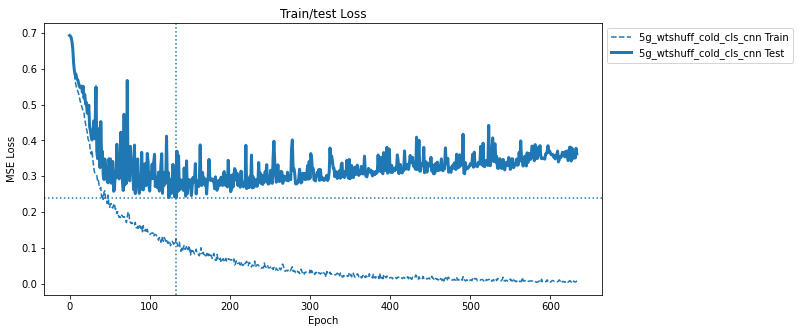

In [45]:
cnn3_name = "5g_wtshuff_cold_cls_cnn"

model5 = m.DNA_2CNN_2FC_Multi(seq_len, 2,**m_kwargs)

model_res[cnn3_name] = collect_model_stats(
    cnn3_name,
    seq_len,
    wts_ohe_train_dl,
    wts_ohe_val_dl,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model5,
)

Running cold model, new task, 2 heads


,model_name,split,mac_precision,mac_recall,mac_f1,support
0,"cold model, new task, 2 heads",train,0.994928,0.994912,0.994912,3538
1,"cold model, new task, 2 heads",test,0.901750,0.901584,0.901574,884


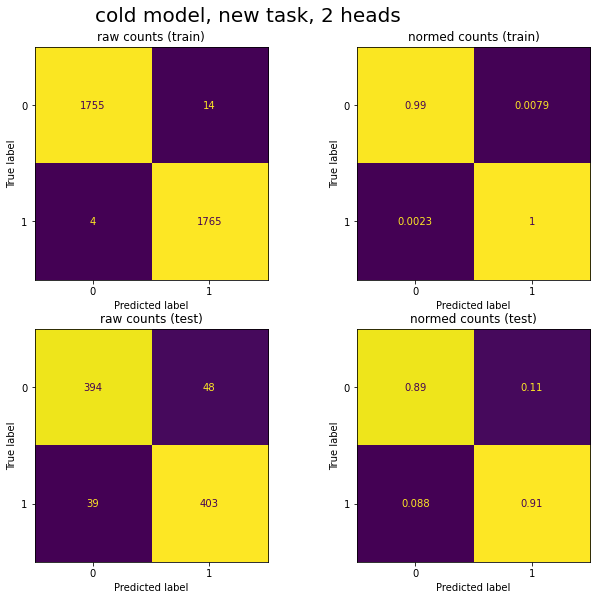

In [46]:
# confusion matrix plotting
seq_list = [
    (wts_train_df["upstream_region"].values,wts_train_df["id"],"train"),
    (wts_test_df["upstream_region"].values,wts_test_df["id"],"test")
]
pred_dfs["cold model, new task, 2 heads"] = get_confusion_stats(
    model5.to(DEVICE),
    "cold model, new task, 2 heads",
    seq_list,
    title=f"cold model, new task, 2 heads"
)

pred_dfs["cold model, new task, 2 heads"]

Running untrained model, new task, 2 heads


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model_name,split,mac_precision,mac_recall,mac_f1,support
0,"untrained model, new task, 2 heads",train,0.25,0.5,0.333333,3538
1,"untrained model, new task, 2 heads",test,0.25,0.5,0.333333,884


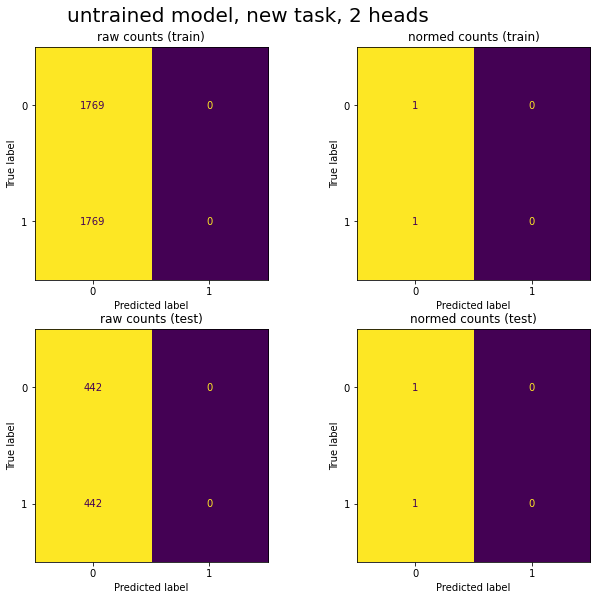

In [47]:
model6 = m.DNA_2CNN_2FC_Multi(seq_len, 2,**m_kwargs)

pred_dfs["untrained model, new task, 2 heads"] = get_confusion_stats(
    model6.to(DEVICE),
    "untrained model, new task, 2 heads",
    seq_list,
    title=f"untrained model, new task, 2 heads"
)

pred_dfs["untrained model, new task, 2 heads"]

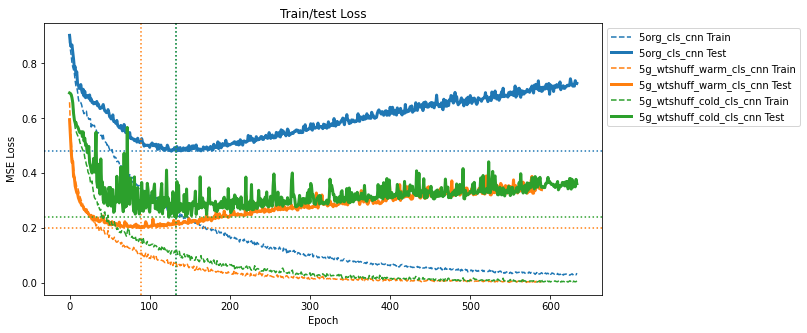

In [48]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

In [50]:
all_preds = pd.concat([pred_dfs[x] for x in pred_dfs])
all_preds

,model_name,split,mac_precision,mac_recall,mac_f1,support
0,5org_cls_cnn,train,0.952919,0.954259,0.953518,15399
1,5org_cls_cnn,test,0.838518,0.836867,0.837538,3850
0,untrained_model,train,0.042535,0.200000,0.070151,15399
1,untrained_model,test,0.042494,0.200000,0.070094,3850
0,pred_shuffled_seq,train shuff,0.402947,0.393001,0.378916,15399
1,pred_shuffled_seq,test shuff,0.389816,0.382543,0.368233,3850
0,reloaded saved CNN,train,0.953473,0.954590,0.953961,15399
1,reloaded saved CNN,test,0.858691,0.857774,0.858161,3850
0,"warm model, 2 heads",train,0.087725,0.194340,0.119746,15399
1,"warm model, 2 heads",test,0.091870,0.202955,0.124942,3850


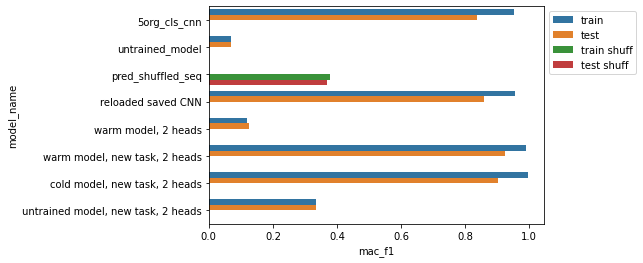

In [57]:
sns.barplot(data=all_preds,y='model_name',x='mac_f1',hue='split',dodge=True)
plt.legend(bbox_to_anchor=(1,1),loc='upper left')


# Ok, try a warm vs cold start for Copper?

In [58]:
XYdf_og

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,...,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,gene,product,type
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.333441,-0.087509,-0.248330,-0.654293,0.0,0.252788,0.260753,...,-0.117634,-0.180709,-0.516711,-0.472602,0.058102,0.668619,0.215153,dnaA,chromosomal replication initiator protein DnaA,CDS
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.179318,-0.183682,-0.493245,-1.323530,0.0,0.418315,0.611021,...,-0.244793,-0.161434,0.237179,-0.079076,0.132689,-0.462317,-0.490073,dnaN,DNA polymerase III subunit beta,CDS
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.364849,0.170159,-0.338861,-0.347147,0.0,0.287824,0.387577,...,-0.249011,-0.066333,-0.987336,-0.990306,0.481623,0.144467,-0.239513,recF,DNA replication/repair protein RecF,CDS
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,0.193539,0.035923,0.136026,-0.642058,0.0,0.189394,0.345084,...,0.643283,0.566397,-0.952383,-0.465515,0.009531,0.367039,0.695145,NaN,hypothetical protein,CDS
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.173256,0.283822,-0.740565,-1.011908,0.0,0.215938,0.306791,...,0.539188,0.622656,-0.716034,-0.025042,0.070784,-0.367242,-0.319915,NaN,bifunctional diguanylate cyclase/phosphodieste...,CDS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.620221,0.718300,0.245892,-1.598809,0.0,0.171579,0.501296,...,0.977712,1.564370,0.701928,1.577361,0.777911,0.463434,0.727701,hxlA,3-hexulose-6-phosphate synthase,CDS
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.609995,0.702416,0.231606,-1.614646,0.0,0.154029,0.483579,...,0.952955,1.548383,0.701457,1.573150,0.761210,0.433925,0.705205,hxlA,3-hexulose-6-phosphate synthase,CDS
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,0.605448,0.688065,0.233752,-1.594922,0.0,0.171939,0.486032,...,0.899683,1.442487,0.708730,1.520411,0.769644,0.032260,0.305817,hxlA,3-hexulose-6-phosphate synthase,CDS
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,0.604488,0.196871,-0.261330,0.125607,0.0,-0.014653,0.229101,...,-0.233161,0.107133,0.265191,-0.870372,0.814080,-0.245552,-0.285502,NaN,transposase,CDS


In [59]:
def set_reg_class_up_down(df, col,thresh=1.0):
    '''
    Given a dataframe of log ratio TPMS, add a column splitting genes into categories
    * Below -thresh: class 0
    * Between -thresh:thresh: class 1
    * Above thresh: class 2
    '''
    def get_class(val):
        if val < -thresh:
            return 0
        elif val > thresh:
            return 2
        else:
            return 1
    
    reg_col = f"{col}_reg_UD"
    df[reg_col] = df[col].apply(lambda x: get_class(x))

In [60]:
XYdf = XYdf_og[~XYdf_og['upstream_region'].str.contains("N")]
XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,...,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,gene,product,type
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.333441,-0.087509,-0.248330,-0.654293,0.0,0.252788,0.260753,...,-0.117634,-0.180709,-0.516711,-0.472602,0.058102,0.668619,0.215153,dnaA,chromosomal replication initiator protein DnaA,CDS
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.179318,-0.183682,-0.493245,-1.323530,0.0,0.418315,0.611021,...,-0.244793,-0.161434,0.237179,-0.079076,0.132689,-0.462317,-0.490073,dnaN,DNA polymerase III subunit beta,CDS
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.364849,0.170159,-0.338861,-0.347147,0.0,0.287824,0.387577,...,-0.249011,-0.066333,-0.987336,-0.990306,0.481623,0.144467,-0.239513,recF,DNA replication/repair protein RecF,CDS
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,0.193539,0.035923,0.136026,-0.642058,0.0,0.189394,0.345084,...,0.643283,0.566397,-0.952383,-0.465515,0.009531,0.367039,0.695145,NaN,hypothetical protein,CDS
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.173256,0.283822,-0.740565,-1.011908,0.0,0.215938,0.306791,...,0.539188,0.622656,-0.716034,-0.025042,0.070784,-0.367242,-0.319915,NaN,bifunctional diguanylate cyclase/phosphodieste...,CDS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.620221,0.718300,0.245892,-1.598809,0.0,0.171579,0.501296,...,0.977712,1.564370,0.701928,1.577361,0.777911,0.463434,0.727701,hxlA,3-hexulose-6-phosphate synthase,CDS
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.609995,0.702416,0.231606,-1.614646,0.0,0.154029,0.483579,...,0.952955,1.548383,0.701457,1.573150,0.761210,0.433925,0.705205,hxlA,3-hexulose-6-phosphate synthase,CDS
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,0.605448,0.688065,0.233752,-1.594922,0.0,0.171939,0.486032,...,0.899683,1.442487,0.708730,1.520411,0.769644,0.032260,0.305817,hxlA,3-hexulose-6-phosphate synthase,CDS
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,0.604488,0.196871,-0.261330,0.125607,0.0,-0.014653,0.229101,...,-0.233161,0.107133,0.265191,-0.870372,0.814080,-0.245552,-0.285502,NaN,transposase,CDS


In [61]:
set_reg_class_up_down(XYdf,'highCu',thresh=0.6)
XYdf['highCu_reg_UD'].value_counts()


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    1957
2     158
0      95
Name: highCu_reg_UD, dtype: int64

_____Split 0____
Train: 1    1565
2     127
0      76
Name: highCu_reg_UD, dtype: int64
Test: 1    392
2     31
0     19
Name: highCu_reg_UD, dtype: int64


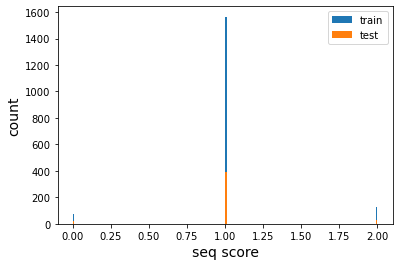

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


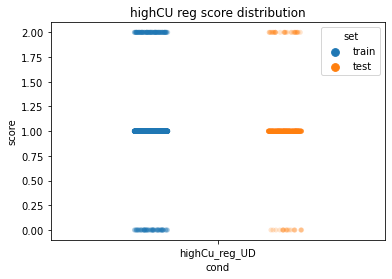

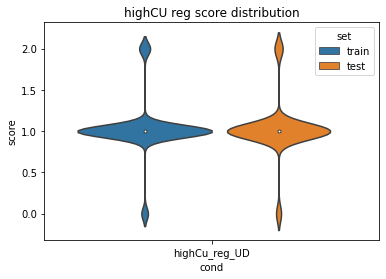

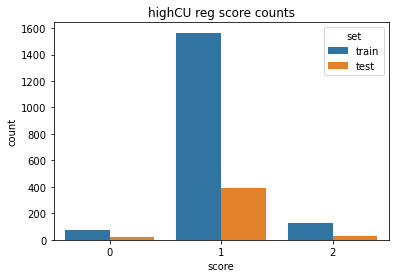


_____Split 1____
Train: 1    1565
2     127
0      76
Name: highCu_reg_UD, dtype: int64
Test: 1    392
2     31
0     19
Name: highCu_reg_UD, dtype: int64


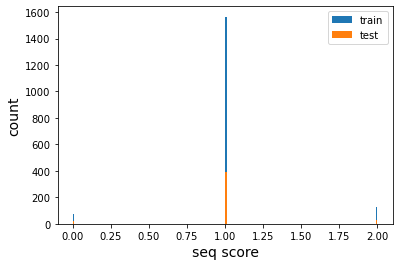

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


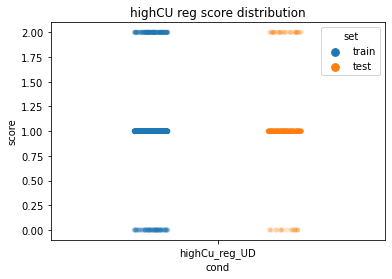

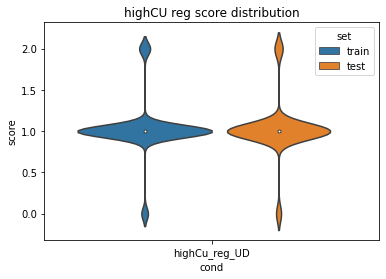

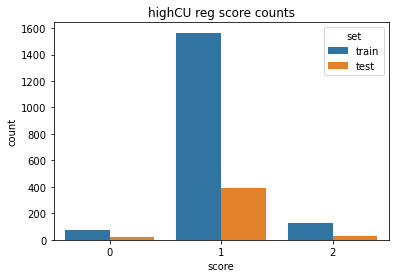


_____Split 2____
Train: 1    1566
2     126
0      76
Name: highCu_reg_UD, dtype: int64
Test: 1    391
2     32
0     19
Name: highCu_reg_UD, dtype: int64


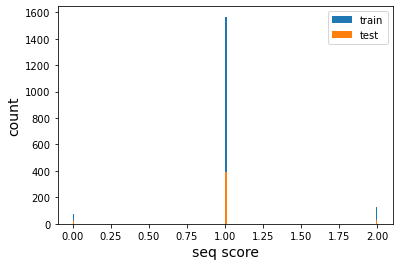

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


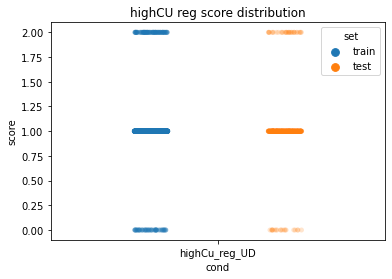

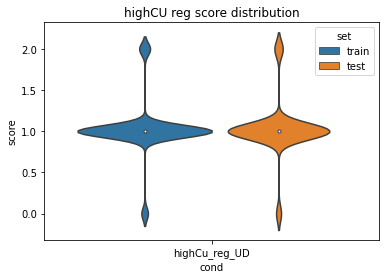

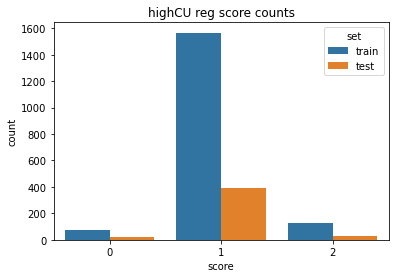


_____Split 3____
Train: 1    1566
2     126
0      76
Name: highCu_reg_UD, dtype: int64
Test: 1    391
2     32
0     19
Name: highCu_reg_UD, dtype: int64


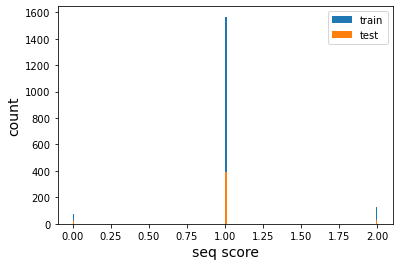

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


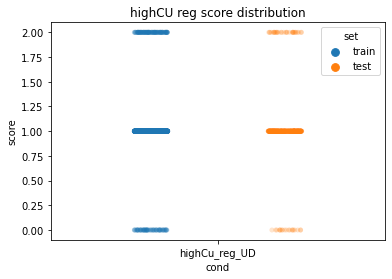

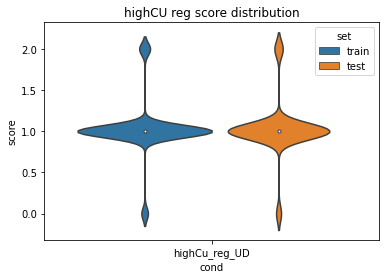

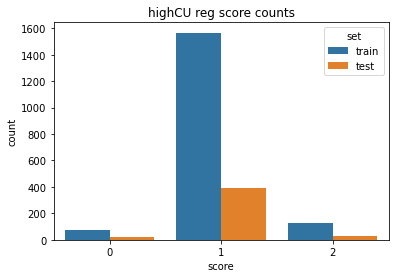


_____Split 4____
Train: 1    1566
2     126
0      76
Name: highCu_reg_UD, dtype: int64
Test: 1    391
2     32
0     19
Name: highCu_reg_UD, dtype: int64


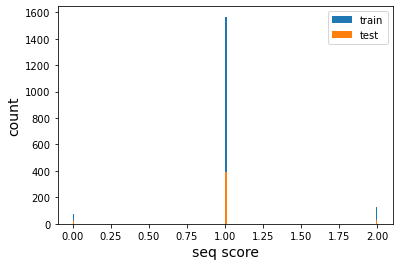

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


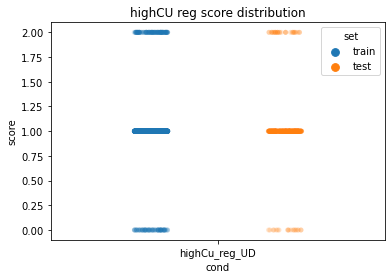

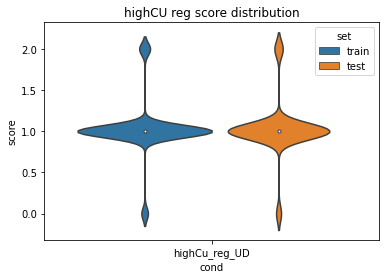

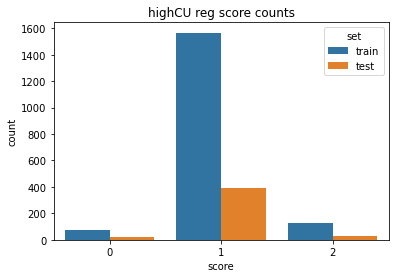

In [65]:
skf = StratifiedKFold(n_splits=5,shuffle=True)
score_col = 'highCu_reg_UD'

for i, (train_idxs, test_idxs) in enumerate(skf.split(XYdf, XYdf[score_col])):
    print(f"_____Split {i}____")
    cu_train_df = XYdf.iloc[train_idxs]
    cu_test_df = XYdf.iloc[test_idxs]
    print("Train:",cu_train_df['highCu_reg_UD'].value_counts())
    print("Test:",cu_test_df['highCu_reg_UD'].value_counts())

    plot_train_test_hist(cu_train_df, cu_test_df,score_col=score_col,bins=200)
    view_train_test_dist(cu_train_df, cu_test_df,[score_col],"highCU reg score",id_col='locus_tag')
    
    print("")
    
    cu_split_dfs = {
        'train':cu_train_df,
        'test':cu_train_df
    }
    
    cu_train_df.to_csv(f'data/5g_UDCu_splits/cv{i}_train.tsv',index=False,sep='\t')
    cu_test_df.to_csv(f'data/5g_UDCu_splits/cv{i}_test.tsv',index=False,sep='\t')

In [67]:
cu_train_df

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,...,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,gene,product,type,highCu_reg_UD,set
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.333441,-0.087509,-0.248330,-0.654293,0.0,0.252788,0.260753,...,-0.516711,-0.472602,0.058102,0.668619,0.215153,dnaA,chromosomal replication initiator protein DnaA,CDS,1,train
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.179318,-0.183682,-0.493245,-1.323530,0.0,0.418315,0.611021,...,0.237179,-0.079076,0.132689,-0.462317,-0.490073,dnaN,DNA polymerase III subunit beta,CDS,2,train
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,0.193539,0.035923,0.136026,-0.642058,0.0,0.189394,0.345084,...,-0.952383,-0.465515,0.009531,0.367039,0.695145,NaN,hypothetical protein,CDS,1,train
5,12,EQU24_RS00080,CCCAGACTGAACGCAACAGGATCGATATTAGGATAAGTCAGCATTT...,0.511466,-0.169779,-0.228529,-0.178561,0.0,0.093169,0.023929,...,-1.157175,-0.792139,0.052329,0.342699,0.193055,NaN,2OG-Fe(II) oxygenase,CDS,1,train
6,13,EQU24_RS00085,TTACCGGGCCGGATTTTTTGACATAGTTCGTTTAGGGTTGGCAATT...,0.740319,0.089523,0.033533,-0.419899,0.0,0.811799,0.821546,...,0.145508,0.251882,1.126993,-0.156899,-0.163949,lgt,prolipoprotein diacylglyceryl transferase,CDS,2,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2204,4176,EQU24_RS23115,TTCAAATCTTGCTTTGAGTCAGTAAATAGTAAGGTACTTTTGTTAA...,0.946831,0.482641,0.497547,0.324126,0.0,0.257141,0.176458,...,0.695719,-0.128286,1.279768,1.762063,1.280904,NaN,hypothetical protein,CDS,1,train
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.620221,0.718300,0.245892,-1.598809,0.0,0.171579,0.501296,...,0.701928,1.577361,0.777911,0.463434,0.727701,hxlA,3-hexulose-6-phosphate synthase,CDS,1,train
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.609995,0.702416,0.231606,-1.614646,0.0,0.154029,0.483579,...,0.701457,1.573150,0.761210,0.433925,0.705205,hxlA,3-hexulose-6-phosphate synthase,CDS,1,train
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,0.605448,0.688065,0.233752,-1.594922,0.0,0.171939,0.486032,...,0.708730,1.520411,0.769644,0.032260,0.305817,hxlA,3-hexulose-6-phosphate synthase,CDS,1,train


## Train a cold model on CU classification

In [68]:
target_col = 'highCu_reg_UD'
cu_sampler = tu.make_weighted_sampler(cu_train_df,target_col)

cu_dls = tu.build_dataloaders_single(
                cu_train_df, 
                cu_test_df, 
                dataset_types, # just OHE for now
                seq_col='upstream_region',
                target_col=target_col,
                sampler=cu_sampler,
                shuffle=False,
            )
cu_ohe_train_dl,cu_ohe_val_dl = cu_dls['ohe']

E:176 | train loss:0.050 | val loss: 0.903:   4%|▎         | 176/5000 [00:13<06:21, 12.65it/s]

EarlyStopping counter: 125 out of 500


E:301 | train loss:0.028 | val loss: 1.076:   6%|▌         | 302/5000 [00:23<06:04, 12.90it/s]

EarlyStopping counter: 250 out of 500


E:426 | train loss:0.014 | val loss: 1.181:   9%|▊         | 426/5000 [00:33<06:00, 12.67it/s]

EarlyStopping counter: 375 out of 500


E:549 | train loss:0.009 | val loss: 1.227:  11%|█         | 549/5000 [00:43<05:50, 12.69it/s]


EarlyStopping counter: 500 out of 500
Early stopping


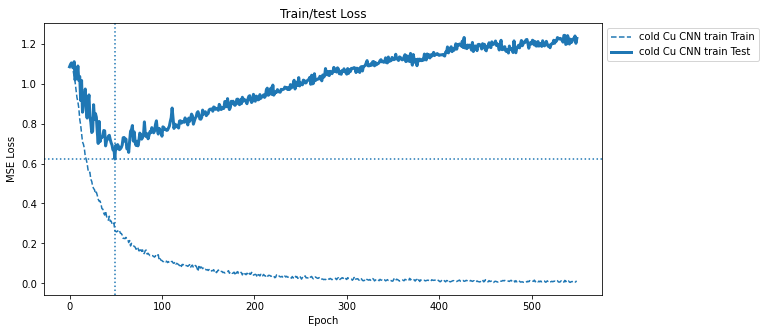

In [69]:
cnn10_name = "cold Cu CNN train"

model10 = m.DNA_2CNN_2FC_Multi(seq_len, 3,**m_kwargs)

model_res[cnn10_name] = collect_model_stats(
    cnn10_name,
    seq_len,
    cu_ohe_train_dl,
    cu_ohe_val_dl,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model10,
)

Running cold Cu CNN train


,model_name,split,mac_precision,mac_recall,mac_f1,support
0,cold Cu CNN train,train,0.793548,0.955969,0.859095,1768
1,cold Cu CNN train,test,0.411881,0.379704,0.390265,442


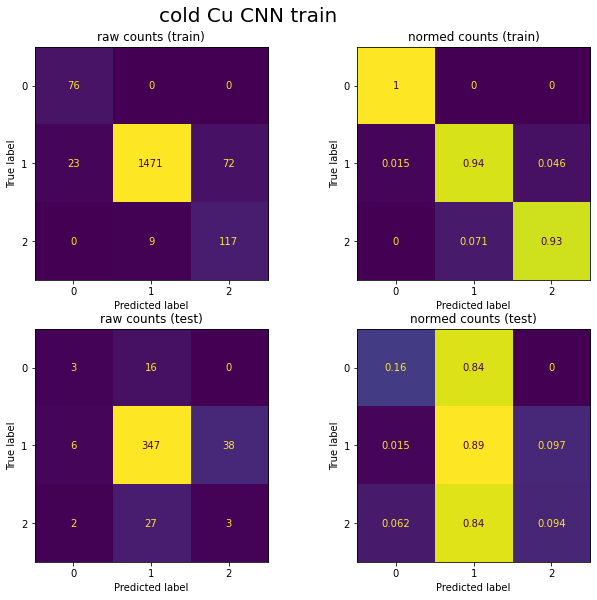

In [70]:
seq_list = [
    (cu_train_df["upstream_region"].values,cu_train_df[target_col],"train"),
    (cu_test_df["upstream_region"].values,cu_test_df[target_col],"test")
]

pred_dfs[cnn10_name] = get_confusion_stats(
    model_res[cnn10_name]['model'],
    model_res[cnn10_name]['model_name'],
    seq_list,
    title=cnn10_name
)

pred_dfs[cnn10_name]

## Train a warm start model on CU classification

In [71]:
model11 = m.DNA_2CNN_2FC_Multi(seq_len, 3,**m_kwargs)
model11.load_state_dict(extracted_layers,strict=False)

_IncompatibleKeys(missing_keys=['conv_net.12.weight', 'conv_net.12.bias'], unexpected_keys=[])

In [72]:
model11

DNA_2CNN_2FC_Multi(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 10), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 6), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten()
    (8): Linear(in_features=4480, out_features=50, bias=True)
    (9): ReLU()
    (10): Linear(in_features=50, out_features=50, bias=True)
    (11): ReLU()
    (12): Linear(in_features=50, out_features=3, bias=True)
  )
)

E:200 | train loss:0.045 | val loss: 0.862:   4%|▍         | 201/5000 [00:16<06:22, 12.53it/s]

EarlyStopping counter: 125 out of 500


E:325 | train loss:0.019 | val loss: 1.021:   6%|▋         | 325/5000 [00:26<06:03, 12.88it/s]

EarlyStopping counter: 250 out of 500


E:450 | train loss:0.010 | val loss: 1.146:   9%|▉         | 451/5000 [00:35<05:51, 12.93it/s]

EarlyStopping counter: 375 out of 500


E:573 | train loss:0.006 | val loss: 1.219:  11%|█▏        | 573/5000 [00:45<05:52, 12.57it/s]


EarlyStopping counter: 500 out of 500
Early stopping


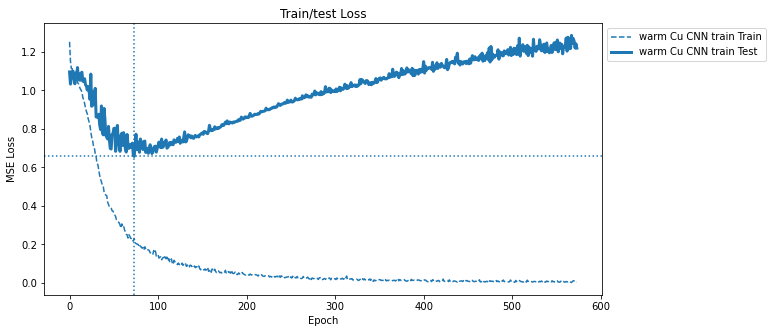

Running warm Cu CNN train


,model_name,split,mac_precision,mac_recall,mac_f1,support
0,warm Cu CNN train,train,0.785658,0.978289,0.860500,1768
1,warm Cu CNN train,test,0.378766,0.385858,0.381414,442


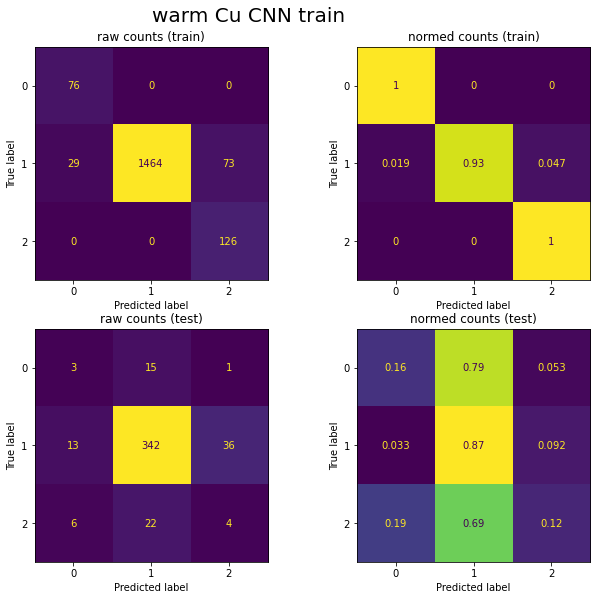

In [73]:
cnn11_name = "warm Cu CNN train"

model_res[cnn11_name] = collect_model_stats(
    cnn11_name,
    seq_len,
    cu_ohe_train_dl,
    cu_ohe_val_dl,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model11,
)

pred_dfs[cnn11_name] = get_confusion_stats(
    model_res[cnn11_name]['model'],
    model_res[cnn11_name]['model_name'],
    seq_list,
    title=cnn11_name
)

pred_dfs[cnn11_name]


In [89]:
model12 = m.DNA_2CNN_2FC_Multi(seq_len, 3,**m_kwargs)
model12.load_state_dict(extracted_layers,strict=False)

opt12 = torch.optim.Adam(model12.parameters())
opt12.load_state_dict(torch.load('saved_models/5org_cls_cv0_opt_state_dict.pt'))

In [94]:
opt12.state_dict()['param_groups']

[{'lr': 0.0001,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False,
  'params': [140664006167120,
   140664006164800,
   140664005052768,
   140664005054208,
   140664005051328,
   140664005051248,
   140664005053328,
   140664005051728,
   140664005052128,
   140664005052608]}]

In [96]:
# warm start opt too?

# model12 = m.DNA_2CNN_2FC_Multi(seq_len, 3,**m_kwargs)
# model12.load_state_dict(extracted_layers,strict=False)

# #opt12 = torch.optim.Adam(model12.parameters())
# #opt12.load_state_dict(torch.load('saved_models/5org_cls_cv0_opt_state_dict.pt'))
# opt12_path = 'saved_models/5org_cls_cv0_opt_state_dict.pt'

# cnn12_name = "warm Cu CNN, warm opt train"

# model_res[cnn12_name] = collect_model_stats(
#     cnn12_name,
#     seq_len,
#     cu_ohe_train_dl,
#     cu_ohe_val_dl,
#     lr=0.0001,
#     ep=5000,
#     pat=500,
#     opt=torch.optim.Adam,#model_res[cnn1_name]['opt'],
#     opt_warm=opt12_path,
#     model=model12,
# )

# pred_dfs[cnn12_name] = get_confusion_stats(
#     model_res[cnn12_name]['model'],
#     model_res[cnn12_name]['model_name'],
#     seq_list,
#     title=cnn12_name
# )

# pred_dfs[cnn12_name]



In [95]:
# Can't figure out how to warm start the optimizer... maybes its not needed...?

# 5-fold warm start

Running CV0


E:207 | train loss:0.032 | val loss: 0.903:   4%|▍         | 208/5000 [00:16<06:11, 12.90it/s]

EarlyStopping counter: 125 out of 500


E:332 | train loss:0.010 | val loss: 1.058:   7%|▋         | 332/5000 [00:25<05:58, 13.02it/s]

EarlyStopping counter: 250 out of 500


E:457 | train loss:0.005 | val loss: 1.170:   9%|▉         | 458/5000 [00:35<05:47, 13.06it/s]

EarlyStopping counter: 375 out of 500


E:580 | train loss:0.013 | val loss: 1.215:  12%|█▏        | 580/5000 [00:44<05:42, 12.92it/s]


EarlyStopping counter: 500 out of 500
Early stopping


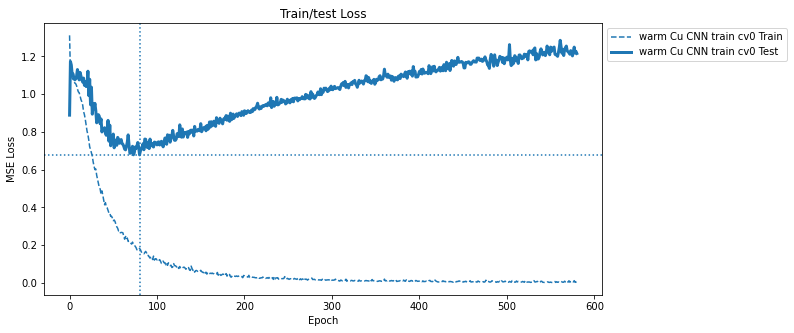

Running warm Cu CNN train cv0
Running CV1


E:198 | train loss:0.032 | val loss: 0.797:   4%|▍         | 198/5000 [00:15<06:04, 13.17it/s]

EarlyStopping counter: 125 out of 500


E:323 | train loss:0.011 | val loss: 0.988:   6%|▋         | 324/5000 [00:24<06:02, 12.89it/s]

EarlyStopping counter: 250 out of 500


E:448 | train loss:0.003 | val loss: 1.192:   9%|▉         | 448/5000 [00:34<05:51, 12.93it/s]

EarlyStopping counter: 375 out of 500


E:571 | train loss:0.002 | val loss: 1.298:  11%|█▏        | 571/5000 [00:43<05:39, 13.04it/s]


EarlyStopping counter: 500 out of 500
Early stopping


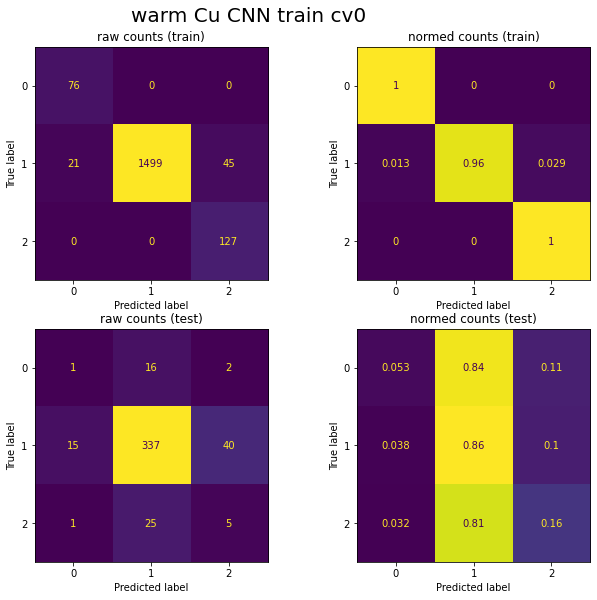

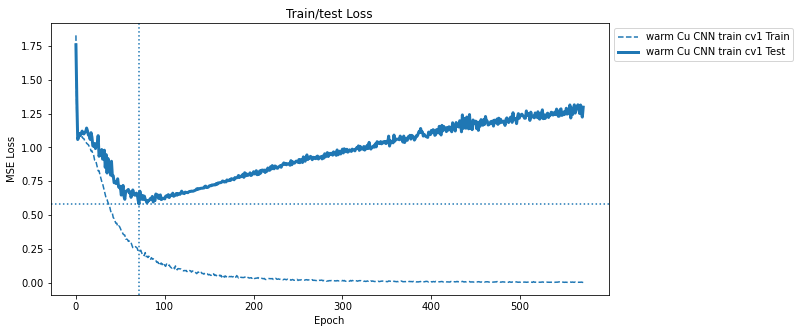

Running warm Cu CNN train cv1
Running CV2


E:185 | train loss:0.042 | val loss: 0.876:   4%|▎         | 186/5000 [00:14<06:09, 13.04it/s]

EarlyStopping counter: 125 out of 500


E:310 | train loss:0.018 | val loss: 1.048:   6%|▌         | 310/5000 [00:23<05:56, 13.16it/s]

EarlyStopping counter: 250 out of 500


E:435 | train loss:0.008 | val loss: 1.199:   9%|▊         | 436/5000 [00:33<05:48, 13.11it/s]

EarlyStopping counter: 375 out of 500


E:558 | train loss:0.006 | val loss: 1.279:  11%|█         | 558/5000 [00:42<05:39, 13.07it/s]


EarlyStopping counter: 500 out of 500
Early stopping


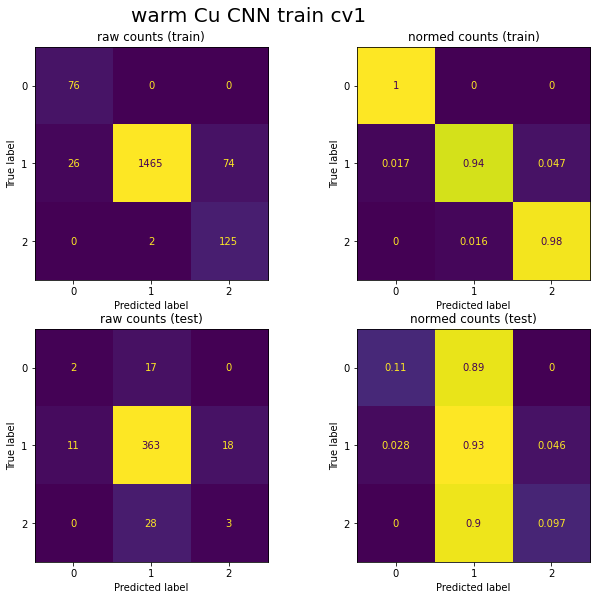

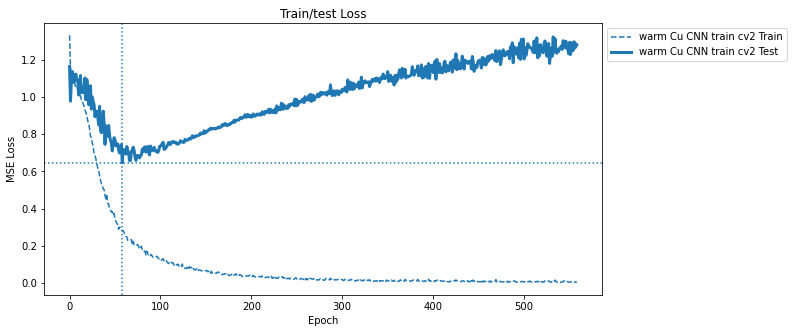

Running warm Cu CNN train cv2
Running CV3


E:198 | train loss:0.033 | val loss: 1.007:   4%|▍         | 199/5000 [00:15<06:05, 13.15it/s]

EarlyStopping counter: 125 out of 500


E:323 | train loss:0.016 | val loss: 1.178:   6%|▋         | 323/5000 [00:24<05:57, 13.09it/s]

EarlyStopping counter: 250 out of 500


E:448 | train loss:0.005 | val loss: 1.311:   9%|▉         | 449/5000 [00:34<05:53, 12.87it/s]

EarlyStopping counter: 375 out of 500


E:571 | train loss:0.012 | val loss: 1.406:  11%|█▏        | 571/5000 [00:44<05:41, 12.97it/s]


EarlyStopping counter: 500 out of 500
Early stopping


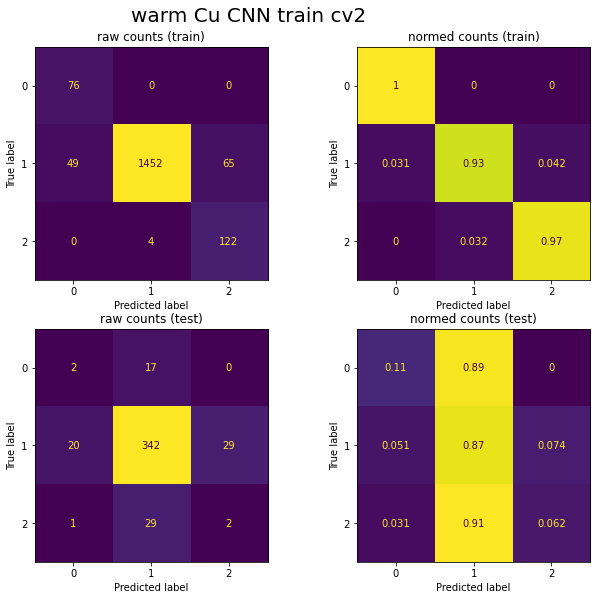

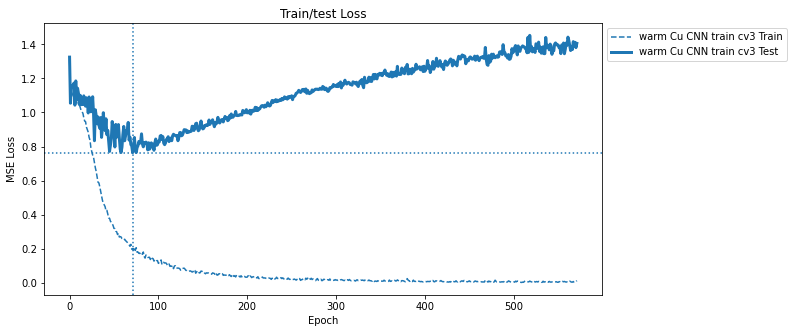

Running warm Cu CNN train cv3
Running CV4


E:199 | train loss:0.020 | val loss: 0.824:   4%|▍         | 200/5000 [00:15<06:07, 13.07it/s]

EarlyStopping counter: 125 out of 500


E:324 | train loss:0.007 | val loss: 0.962:   6%|▋         | 324/5000 [00:24<05:54, 13.17it/s]

EarlyStopping counter: 250 out of 500


E:449 | train loss:0.003 | val loss: 1.055:   9%|▉         | 450/5000 [00:34<05:44, 13.20it/s]

EarlyStopping counter: 375 out of 500


E:572 | train loss:0.003 | val loss: 1.157:  11%|█▏        | 572/5000 [00:43<05:37, 13.11it/s]


EarlyStopping counter: 500 out of 500
Early stopping


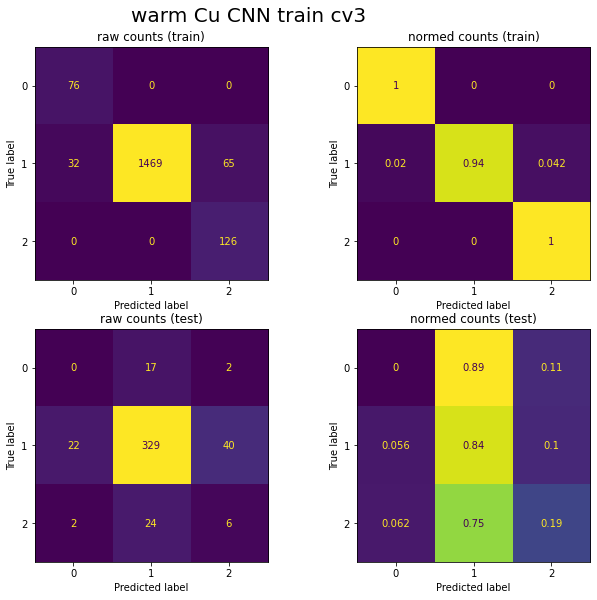

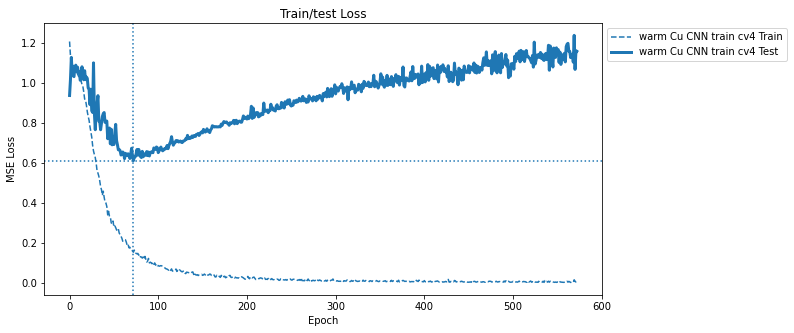

Running warm Cu CNN train cv4


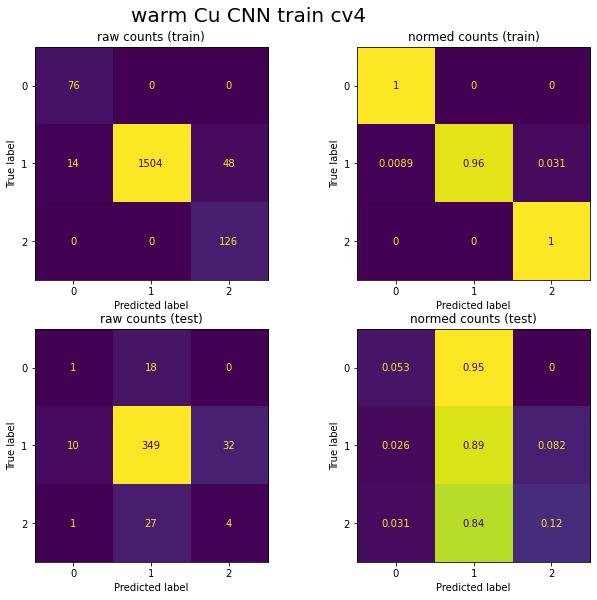

In [98]:
cv_names = []
for i in [0,1,2,3,4]:
    print(f"Running CV{i}")
    cu_train_df = pd.read_csv(f'data/5g_UDCu_splits/cv{i}_train.tsv',sep='\t')
    cu_test_df = pd.read_csv(f'data/5g_UDCu_splits/cv{i}_test.tsv',sep='\t')
    
    target_col = 'highCu_reg_UD'
    cu_sampler = tu.make_weighted_sampler(cu_train_df,target_col)

    cu_dls = tu.build_dataloaders_single(
                    cu_train_df, 
                    cu_test_df, 
                    dataset_types, # just OHE for now
                    seq_col='upstream_region',
                    target_col=target_col,
                    sampler=cu_sampler,
                    shuffle=False,
                )
    cu_ohe_train_dl,cu_ohe_val_dl = cu_dls['ohe']
    
    model_cv = m.DNA_2CNN_2FC_Multi(seq_len, 3,**m_kwargs)
    model_cv.load_state_dict(extracted_layers,strict=False)
    
    cnn_cv_name = f"warm Cu CNN train cv{i}"

    model_res[cnn_cv_name] = collect_model_stats(
        cnn_cv_name,
        seq_len,
        cu_ohe_train_dl,
        cu_ohe_val_dl,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model_cv,
    )

    seq_list = [
        (cu_train_df["upstream_region"].values,cu_train_df[target_col],"train"),
        (cu_test_df["upstream_region"].values,cu_test_df[target_col],"test")
    ]
    
    pred_dfs[cnn_cv_name] = get_confusion_stats(
        model_res[cnn_cv_name]['model'],
        model_res[cnn_cv_name]['model_name'],
        seq_list,
        title=cnn_cv_name
    )

    cv_names.append(cnn_cv_name)

    

Running CV0


E:176 | train loss:0.042 | val loss: 1.007:   4%|▎         | 176/5000 [00:13<06:07, 13.14it/s]

EarlyStopping counter: 125 out of 500


E:301 | train loss:0.017 | val loss: 1.119:   6%|▌         | 302/5000 [00:23<05:59, 13.07it/s]

EarlyStopping counter: 250 out of 500


E:426 | train loss:0.015 | val loss: 1.221:   9%|▊         | 426/5000 [00:32<05:47, 13.17it/s]

EarlyStopping counter: 375 out of 500


E:549 | train loss:0.004 | val loss: 1.276:  11%|█         | 549/5000 [00:42<05:41, 13.03it/s]


EarlyStopping counter: 500 out of 500
Early stopping


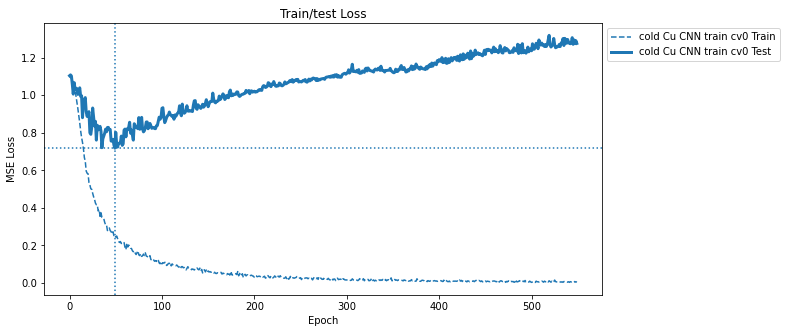

Running cold Cu CNN train cv0
Running CV1


E:187 | train loss:0.057 | val loss: 0.783:   4%|▍         | 188/5000 [00:14<06:14, 12.85it/s]

EarlyStopping counter: 125 out of 500


E:312 | train loss:0.010 | val loss: 0.933:   6%|▌         | 312/5000 [00:24<06:01, 12.96it/s]

EarlyStopping counter: 250 out of 500


E:437 | train loss:0.009 | val loss: 1.009:   9%|▉         | 438/5000 [00:34<05:55, 12.85it/s]

EarlyStopping counter: 375 out of 500


E:560 | train loss:0.004 | val loss: 1.072:  11%|█         | 560/5000 [00:43<05:45, 12.84it/s]


EarlyStopping counter: 500 out of 500
Early stopping


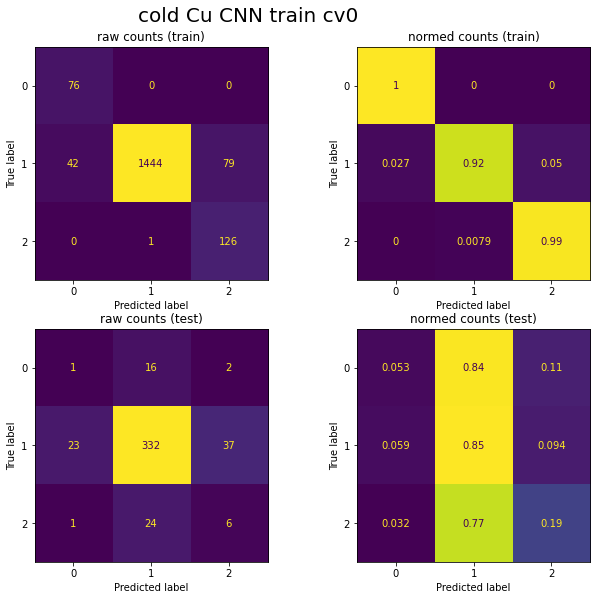

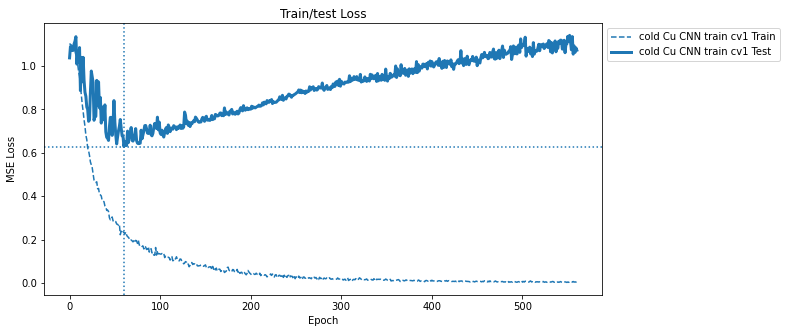

Running cold Cu CNN train cv1
Running CV2


E:167 | train loss:0.063 | val loss: 0.825:   3%|▎         | 168/5000 [00:13<06:09, 13.09it/s]

EarlyStopping counter: 125 out of 500


E:292 | train loss:0.020 | val loss: 0.943:   6%|▌         | 292/5000 [00:22<06:08, 12.79it/s]

EarlyStopping counter: 250 out of 500


E:417 | train loss:0.011 | val loss: 1.052:   8%|▊         | 418/5000 [00:32<05:53, 12.97it/s]

EarlyStopping counter: 375 out of 500


E:540 | train loss:0.012 | val loss: 1.051:  11%|█         | 540/5000 [00:41<05:45, 12.92it/s]


EarlyStopping counter: 500 out of 500
Early stopping


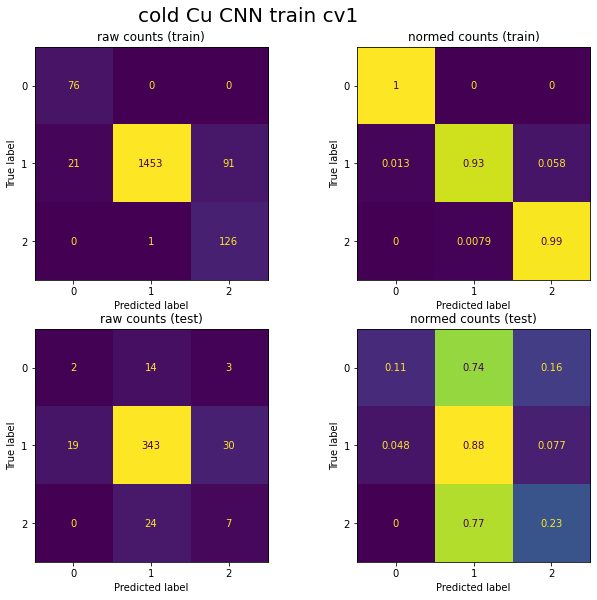

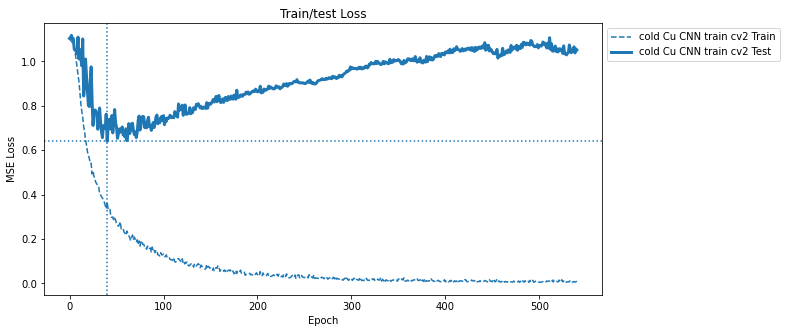

Running cold Cu CNN train cv2
Running CV3


E:153 | train loss:0.057 | val loss: 0.938:   3%|▎         | 154/5000 [00:11<06:08, 13.16it/s]

EarlyStopping counter: 125 out of 500


E:278 | train loss:0.024 | val loss: 1.081:   6%|▌         | 278/5000 [00:21<05:58, 13.15it/s]

EarlyStopping counter: 250 out of 500


E:403 | train loss:0.012 | val loss: 1.199:   8%|▊         | 404/5000 [00:30<05:51, 13.09it/s]

EarlyStopping counter: 375 out of 500


E:526 | train loss:0.009 | val loss: 1.236:  11%|█         | 526/5000 [00:40<05:43, 13.04it/s]


EarlyStopping counter: 500 out of 500
Early stopping


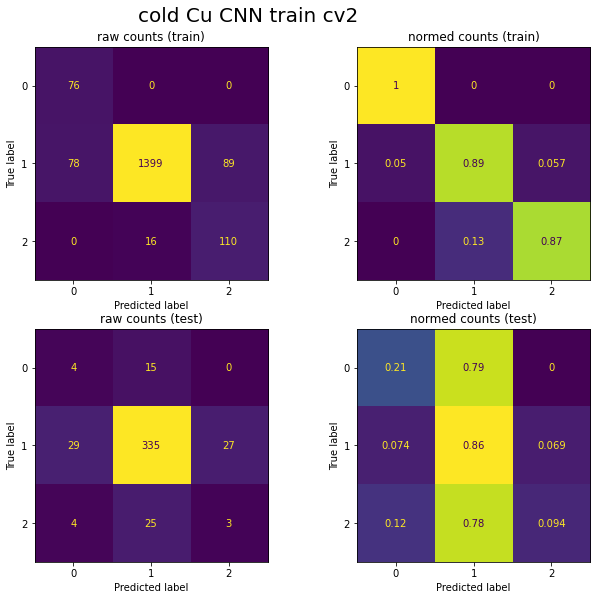

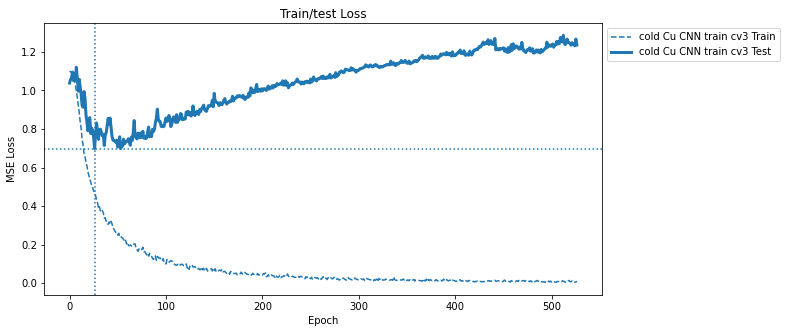

Running cold Cu CNN train cv3
Running CV4


E:171 | train loss:0.066 | val loss: 0.916:   3%|▎         | 172/5000 [00:13<06:12, 12.96it/s]

EarlyStopping counter: 125 out of 500


E:296 | train loss:0.026 | val loss: 1.063:   6%|▌         | 296/5000 [00:22<05:57, 13.16it/s]

EarlyStopping counter: 250 out of 500


E:421 | train loss:0.009 | val loss: 1.155:   8%|▊         | 422/5000 [00:32<05:53, 12.96it/s]

EarlyStopping counter: 375 out of 500


E:544 | train loss:0.011 | val loss: 1.212:  11%|█         | 544/5000 [00:41<05:42, 13.01it/s]


EarlyStopping counter: 500 out of 500
Early stopping


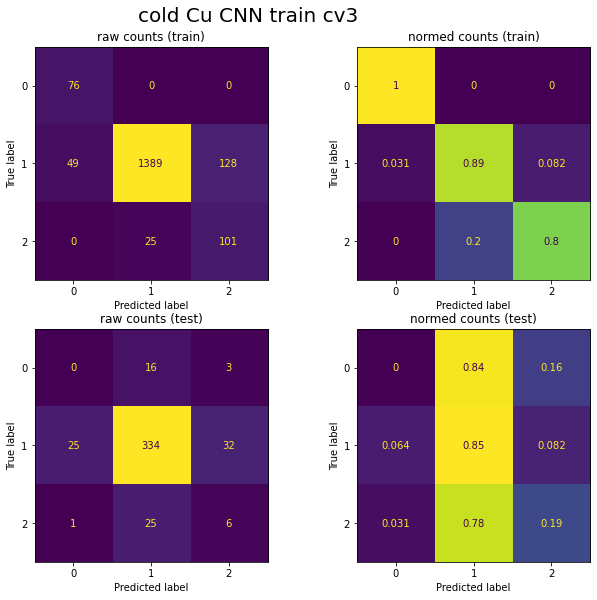

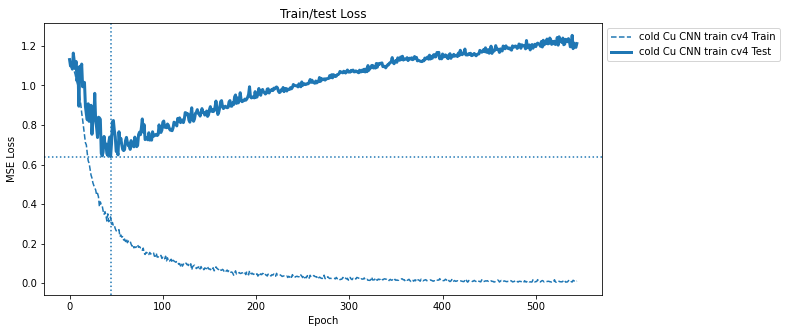

Running cold Cu CNN train cv4


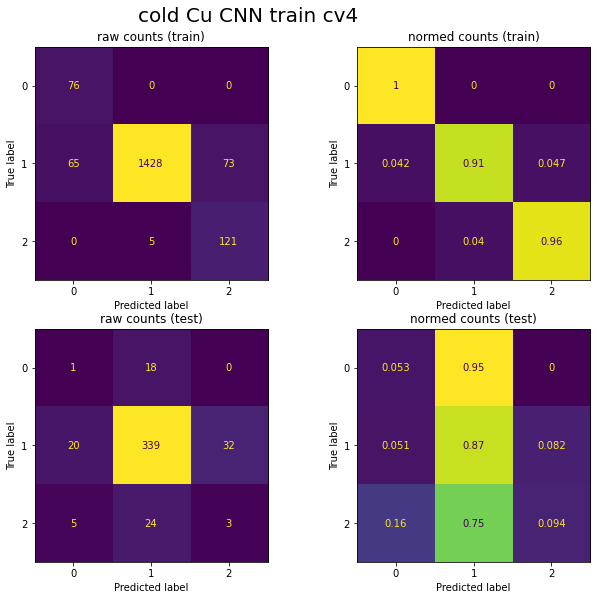

In [99]:
# COLD STARTS

for i in [0,1,2,3,4]:
    print(f"Running CV{i}")
    cu_train_df = pd.read_csv(f'data/5g_UDCu_splits/cv{i}_train.tsv',sep='\t')
    cu_test_df = pd.read_csv(f'data/5g_UDCu_splits/cv{i}_test.tsv',sep='\t')
    
    target_col = 'highCu_reg_UD'
    cu_sampler = tu.make_weighted_sampler(cu_train_df,target_col)

    cu_dls = tu.build_dataloaders_single(
                    cu_train_df, 
                    cu_test_df, 
                    dataset_types, # just OHE for now
                    seq_col='upstream_region',
                    target_col=target_col,
                    sampler=cu_sampler,
                    shuffle=False,
                )
    cu_ohe_train_dl,cu_ohe_val_dl = cu_dls['ohe']
    
    model_cv = m.DNA_2CNN_2FC_Multi(seq_len, 3,**m_kwargs)
    #model_cv.load_state_dict(extracted_layers,strict=False)
    
    cnn_cv_name = f"cold Cu CNN train cv{i}"

    model_res[cnn_cv_name] = collect_model_stats(
        cnn_cv_name,
        seq_len,
        cu_ohe_train_dl,
        cu_ohe_val_dl,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model_cv,
    )
    seq_list = [
        (cu_train_df["upstream_region"].values,cu_train_df[target_col],"train"),
        (cu_test_df["upstream_region"].values,cu_test_df[target_col],"test")
    ]
    
    pred_dfs[cnn_cv_name] = get_confusion_stats(
        model_res[cnn_cv_name]['model'],
        model_res[cnn_cv_name]['model_name'],
        seq_list,
        title=cnn_cv_name
    )

    cv_names.append(cnn_cv_name)

In [ ]:
# PLOT WARMS VS COLDS

In [101]:
pred_dfs.keys()

dict_keys(['5org_cls_cnn', 'untrained_model', 'pred_shuffled_seq', 'reloaded saved CNN', 'warm model, 2 heads', 'warm model, new task, 2 heads', 'cold model, new task, 2 heads', 'untrained model, new task, 2 heads', 'cold Cu CNN train', 'warm Cu CNN train', 'warm Cu CNN train cv0', 'warm Cu CNN train cv1', 'warm Cu CNN train cv2', 'warm Cu CNN train cv3', 'warm Cu CNN train cv4', 'cold Cu CNN train cv0', 'cold Cu CNN train cv1', 'cold Cu CNN train cv2', 'cold Cu CNN train cv3', 'cold Cu CNN train cv4'])

In [107]:
warms = pd.concat([pred_dfs[x] for x in pred_dfs.keys() if x.startswith('warm Cu CNN train cv')])
warms['start'] = 'warm'
colds = pd.concat([pred_dfs[x] for x in pred_dfs.keys() if x.startswith('cold Cu CNN train cv')])
colds['start'] = 'cold'

In [108]:
wc_df = pd.concat([warms,colds])
wc_df

,model_name,split,mac_precision,mac_recall,mac_f1,support,start
0,warm Cu CNN train cv0,train,0.840626,0.985942,0.902190,1768,warm
1,warm Cu CNN train cv0,test,0.352247,0.357872,0.353028,442,warm
0,warm Cu CNN train cv1,train,0.790625,0.973451,0.862388,1768,warm
1,warm Cu CNN train cv1,test,0.395470,0.376019,0.382628,442,warm
0,warm Cu CNN train cv2,train,0.752553,0.965152,0.832242,1768,warm
1,warm Cu CNN train cv2,test,0.344305,0.347481,0.345593,442,warm
0,warm Cu CNN train cv3,train,0.787797,0.979353,0.863026,1768,warm
1,warm Cu CNN train cv3,test,0.338063,0.342977,0.338217,442,warm
0,warm Cu CNN train cv4,train,0.856194,0.986803,0.911822,1768,warm
1,warm Cu CNN train cv4,test,0.360077,0.356738,0.357112,442,warm


In [115]:
def box_swarm_plot(df,metric,split,x_col,yrange=None):
    df_split = df[df['split']==split]
    
    fig = plt.figure(figsize=(5,5))
    #ax = sns.boxplot(data=df_split,x=x_col,y=metric,hue='model_name',dodge=True,boxprops=dict(alpha=.3))
    ax = sns.boxplot(data=df_split,x=x_col,y=metric,hue='start',dodge=True,boxprops=dict(alpha=.3))
    plt.setp(ax.collections,alpha=0.3)

    handles = ax.legend_.legendHandles
    labels = [text.get_text() for text in ax.legend_.texts]

    sns.swarmplot(data=df_split,x=x_col,y=metric,hue='start',
                  dodge=True,edgecolor='black',linewidth=1,ax=ax,size=8)

    plt.legend(handles, labels,loc='best')
    plt.ylim(yrange)
    plt.ylabel(f"{metric} score",fontsize=16)
    plt.xlabel(f"{x_col} variant",fontsize=16)
    plt.title(f"{split} set prediction results",fontsize=20)
    plt.show()

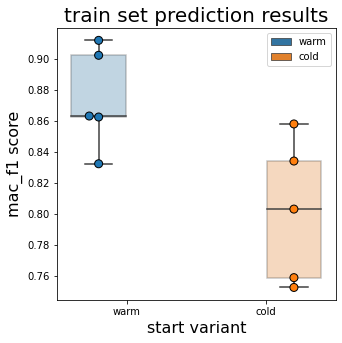

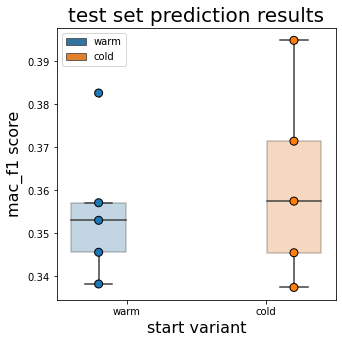

In [117]:
box_swarm_plot(wc_df,'mac_f1','train','start')
box_swarm_plot(wc_df,'mac_f1','test','start')

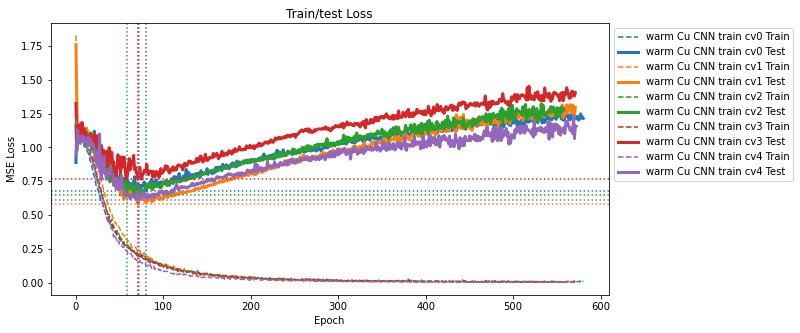

In [120]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in warms['model_name'].unique()])

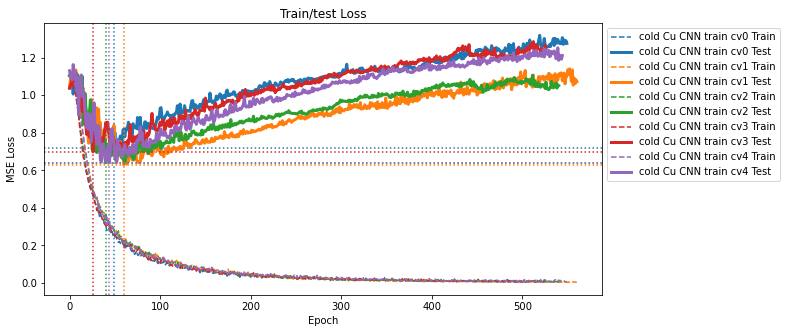

In [121]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in colds['model_name'].unique()])

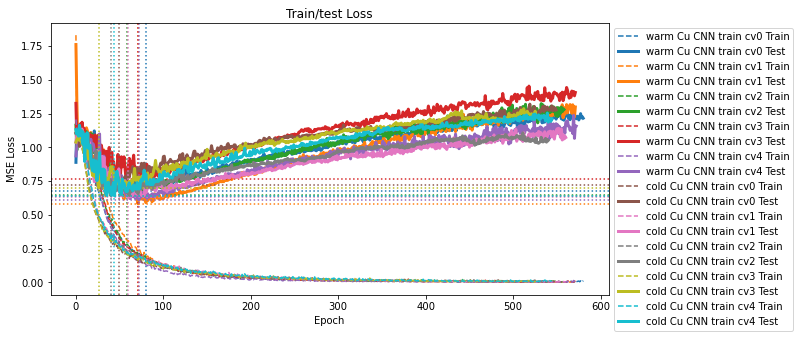

In [122]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in wc_df['model_name'].unique()])